In [1]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [2]:
import sys
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import time

from snntorch import spikegen
import matplotlib.pyplot as plt
import snntorch.spikeplot as splt
from IPython.display import HTML

from tqdm import tqdm

from apex.parallel import DistributedDataParallel as DDP

import random
import datetime

import json

from sklearn.utils import shuffle

''' 레퍼런스
https://spikingjelly.readthedocs.io/zh-cn/0.0.0.0.4/spikingjelly.datasets.html#module-spikingjelly.datasets
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/datasets.py
https://github.com/GorkaAbad/Sneaky-Spikes/blob/main/how_to.md
https://github.com/nmi-lab/torchneuromorphic
https://snntorch.readthedocs.io/en/latest/snntorch.spikevision.spikedata.html#shd
'''

import snntorch
from snntorch.spikevision import spikedata

from spikingjelly.datasets.dvs128_gesture import DVS128Gesture
from spikingjelly.datasets.cifar10_dvs import CIFAR10DVS
from spikingjelly.datasets.n_mnist import NMNIST
# from spikingjelly.datasets.es_imagenet import ESImageNet
from spikingjelly.datasets import split_to_train_test_set
from spikingjelly.datasets.n_caltech101 import NCaltech101
from spikingjelly.datasets import pad_sequence_collate, padded_sequence_mask

import torchneuromorphic

import wandb

from torchviz import make_dot
import graphviz

/tmp/ipykernel_29464/3914466541.py:46: DeprecationWarning: The module snntorch.spikevision is deprecated. For loading neuromorphic datasets, we recommend using the Tonic project: https://github.com/neuromorphs/tonic
  from snntorch.spikevision import spikedata


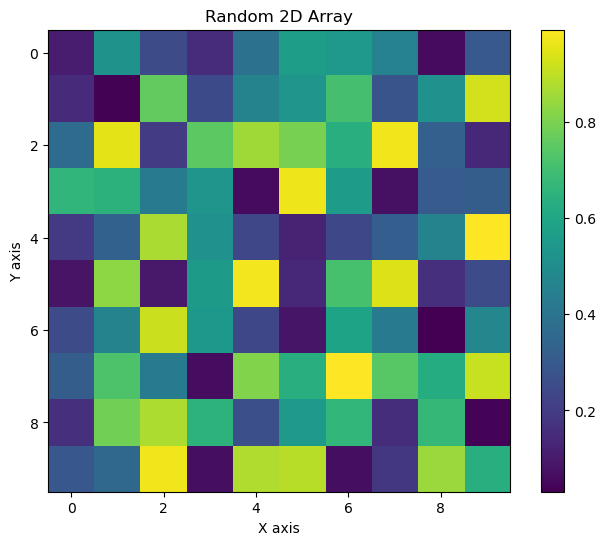

In [3]:
# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈


In [4]:
def my_snn_system(devices = "0,1,2,3",
                    single_step = False, # True # False
                    unique_name = 'main',
                    my_seed = 42,
                    TIME = 10,
                    BATCH = 256,
                    IMAGE_SIZE = 32,
                    which_data = 'CIFAR10',
                    # CLASS_NUM = 10,
                    data_path = '/data2',
                    rate_coding = True,
    
                    lif_layer_v_init = 0.0,
                    lif_layer_v_decay = 0.6,
                    lif_layer_v_threshold = 1.2,
                    lif_layer_v_reset = 0.0,
                    lif_layer_sg_width = 1,

                    # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                    synapse_conv_kernel_size = 3,
                    synapse_conv_stride = 1,
                    synapse_conv_padding = 1,
                    synapse_conv_trace_const1 = 1,
                    synapse_conv_trace_const2 = 0.6,

                    # synapse_fc_out_features = CLASS_NUM,
                    synapse_fc_trace_const1 = 1,
                    synapse_fc_trace_const2 = 0.6,

                    pre_trained = False,
                    convTrue_fcFalse = True,
                    cfg = [64, 64],
                    net_print = False, # True # False
                    weight_count_print = False, # True # False
                    pre_trained_path = "net_save/save_now_net.pth",
                    learning_rate = 0.0001,
                    epoch_num = 200,
                    verbose_interval = 100, #숫자 크게 하면 꺼짐
                    validation_interval = 10, #숫자 크게 하면 꺼짐
                    tdBN_on = False,
                    BN_on = False,

                    surrogate = 'sigmoid',

                    gradient_verbose = False,

                    BPTT_on = False,

                    optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                    scheduler_name = 'no',
                    
                    ddp_on = True,

                    nda_net = False,
                    
                    domain_il_epoch = 0, # over 0, then domain il mode on

                    dvs_clipping = 1, 
                    dvs_duration = 10005,

                    OTTT_sWS_on = True, # True # False

                    DFA_on = False, # True # False
                    OTTT_input_trace_on = False, # True # False
                
                  ):
    ## hyperparameter check #############################################################
    if OTTT_sWS_on == True:
        assert BPTT_on == False and tdBN_on == False and BN_on == False
        if convTrue_fcFalse == False:
            assert single_step == True
    if single_step == True:
        assert BPTT_on == False and tdBN_on == False 
    if tdBN_on == True:
        assert BPTT_on == True
    if pre_trained == True:
        print('\n\n')
        print("Caution! pre_trained is True\n\n"*3)    
    if DFA_on == True:
        assert single_step == True and BPTT_on == False and any(isinstance(item, list) for item in cfg) == False
    if OTTT_input_trace_on == True:
        assert BPTT_on == False and single_step == True
    
    print('\nyour OTTT_sWS_on', OTTT_sWS_on,'\n')
    ######################################################################################


    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    hyperparameters['current epoch'] = 0
    ######################################################################################
    
    
    ## DDP settting ######################################################################
    if (ddp_on == True):
        parser = argparse.ArgumentParser(description='my_snn CIFAR10 Training')

        # # local_rank는 command line에서 따로 줄 필요는 없지만, 선언은 필요
        parser.add_argument("--local_rank", default=0, type=int)

        args = parser.parse_args() # 이거 적어줘야됨. parser argument선언하고

        args.gpu = args.local_rank
        torch.cuda.set_device(args.gpu)
        torch.distributed.init_process_group(backend="nccl", init_method="env://")
        args.world_size = torch.distributed.get_world_size()
    #######################################################################################


    ## wandb 세팅 ###################################################################
    current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    if (ddp_on == True and torch.distributed.get_rank() != 0):
        wandb.finish()
    if (ddp_on == False or torch.distributed.get_rank() == 0):
        wandb.config.update(hyperparameters)
        wandb.run.name = f'lr_{learning_rate}_{unique_name}_{which_data}_tstep{TIME}'
        wandb.define_metric("summary_val_acc", summary="max")
        wandb.run.log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))
    ###################################################################################



    ## gpu setting ##################################################################################################################
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= devices
    ###################################################################################################################################


    ## seed setting ##################################################################################################################
    seed_assign(my_seed)
    ###################################################################################################################################
    

    ## data_loader 가져오기 ##################################################################################################################
    # data loader, pixel channel, class num
    train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM = data_loader(
            which_data,
            data_path, 
            rate_coding, 
            BATCH, 
            IMAGE_SIZE,
            ddp_on,
            TIME,
            dvs_clipping,
            dvs_duration)
    synapse_fc_out_features = CLASS_NUM
    ###########################################################################################################################################

    
    ## parameter number calculator (안 중요함) ##################################################################################################################
    params_num = 0
    img_size = IMAGE_SIZE 
    bias_param = 1 # 1 or 0
    classifier_making = False
    if (convTrue_fcFalse == True):
        past_kernel = synapse_conv_in_channels
        for kernel in cfg:
            if (classifier_making == False):
                if (type(kernel) == list):
                    for residual_kernel in kernel:
                        if (residual_kernel >= 10000 and residual_kernel < 20000): # separable
                            residual_kernel -= 10000
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            params_num += (1**2 * past_kernel + bias_param) * residual_kernel
                            past_kernel = residual_kernel  
                        elif (residual_kernel >= 20000 and residual_kernel < 30000): # depthwise
                            residual_kernel -= 20000
                            # 'past_kernel' should be same with 'kernel'
                            params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                            past_kernel = residual_kernel  
                        else:
                            params_num += residual_kernel * ((synapse_conv_kernel_size**2) * past_kernel + bias_param)
                            past_kernel = residual_kernel
                elif (kernel == 'P' or kernel == 'M'):
                    img_size = img_size // 2
                elif (kernel == 'D'):
                    img_size = 1
                elif (kernel == 'L'):
                    classifier_making = True
                    past_kernel = past_kernel * (img_size**2)
                else:
                    if (kernel >= 10000 and kernel < 20000): # separable
                        kernel -= 10000
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        params_num += (1**2 * past_kernel + bias_param) * kernel
                        past_kernel = kernel  
                    elif (kernel >= 20000 and kernel < 30000): # depthwise
                        kernel -= 20000
                        # 'past_kernel' should be same with 'kernel'
                        params_num += (synapse_conv_kernel_size**2 + bias_param) * past_kernel
                        past_kernel = kernel  
                    else:
                        params_num += kernel * (synapse_conv_kernel_size**2 * past_kernel + bias_param)
                        past_kernel = kernel    
            else: # classifier making
                params_num += (past_kernel + bias_param) * kernel
                past_kernel = kernel
        
        
        if classifier_making == False:
            past_kernel = past_kernel*img_size*img_size

        params_num += (past_kernel + bias_param) * synapse_fc_out_features
    else:
        past_in_channel = synapse_conv_in_channels*img_size*img_size
        for in_channel in cfg:
            if (type(in_channel) == list):
                for residual_in_channel in in_channel:
                    params_num += (past_in_channel + bias_param) * residual_in_channel
                    past_in_channel = residual_in_channel
            elif (in_channel == 'P' or in_channel == 'M'):
                img_size = img_size // 2
                past_in_channel = synapse_conv_in_channels*img_size*img_size
            else:
                params_num += (past_in_channel + bias_param) * in_channel
                past_in_channel = in_channel
        params_num += (past_in_channel + bias_param) * synapse_fc_out_features
    ###########################################################################################################################################


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ### network setting #######################################################################################################################
    if (convTrue_fcFalse == False):
        if (single_step == False):
            net = MY_SNN_FC(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on).to(device)
        else:
            net = MY_SNN_FC_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE, synapse_fc_out_features,
                        synapse_fc_trace_const1, synapse_fc_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        DFA_on,
                        OTTT_sWS_on).to(device)
    else:
        if (single_step == False):
            net = MY_SNN_CONV(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on).to(device)
        else:
            net = MY_SNN_CONV_sstep(cfg, synapse_conv_in_channels, IMAGE_SIZE,
                        synapse_conv_kernel_size, synapse_conv_stride, 
                        synapse_conv_padding, synapse_conv_trace_const1, 
                        synapse_conv_trace_const2, 
                        lif_layer_v_init, lif_layer_v_decay, 
                        lif_layer_v_threshold, lif_layer_v_reset,
                        lif_layer_sg_width,
                        synapse_fc_out_features, synapse_fc_trace_const1, synapse_fc_trace_const2,
                        tdBN_on,
                        BN_on, TIME,
                        surrogate,
                        BPTT_on,
                        OTTT_sWS_on,
                        DFA_on,).to(device)
    if (nda_net == True):
        net = VGG(cfg = cfg, num_classes=10, batch_norm = tdBN_on, in_c = synapse_conv_in_channels, 
                    lif_layer_v_threshold=lif_layer_v_threshold, lif_layer_v_decay=lif_layer_v_decay, lif_layer_sg_width=lif_layer_sg_width)
        net.T = TIME
    if ddp_on == False:
        net = torch.nn.DataParallel(net) 
    
    if pre_trained == True:
        net.load_state_dict(torch.load(pre_trained_path))
    
    if ddp_on == True:
        device = args.gpu
        net = net.to(args.gpu)
        net = DDP(net, delay_allreduce=True)
    else:
        net = net.to(device)


    net = net.to(device)
    if (net_print == True):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print(net)    
    ####################################################################################################################################
    

    ## wandb logging ###########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        wandb.watch(net, log="all", log_freq = 10) #gradient, parameter logging해줌
    ############################################################

    ## param num and memory estimation except BN with MY own calculation some lines above ##########################################
    if ddp_on == False or torch.distributed.get_rank() == 0:
        real_param_num = sum(p.numel() for p in net.parameters() if p.requires_grad)
        if (weight_count_print == True):
            for name, param in net.named_parameters():
                if param.requires_grad:
                    print(f'Layer: {name} | Number of parameters: {param.numel()}')
        # Batch norm 있으면 아래 두 개 서로 다를 수 있음.
        # assert real_param_num == params_num, f'parameter number is not same. real_param_num: {real_param_num}, params_num: {params_num}'    
        print('='*50)
        print(f"My Num of PARAMS: {params_num:,}, system's param_num : {real_param_num:,}")
        memory = params_num / 8 / 1024 / 1024 # MB
        precision = 32
        memory = memory * precision 
        print(f"Memory: {memory:.2f}MiB at {precision}-bit")
        print('='*50)
    ##############################################################################################################################



    ## criterion ########################################## # loss 구해주는 친구
    criterion = nn.CrossEntropyLoss().to(device)
    if (OTTT_sWS_on == True):
        # criterion = nn.CrossEntropyLoss().to(device)
        criterion = lambda y_t, target_t: ((1 - 0.05) * F.cross_entropy(y_t, target_t) + 0.05 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
        if which_data == 'DVS_GESTURE':
            criterion = lambda y_t, target_t: ((1 - 0.001) * F.cross_entropy(y_t, target_t) + 0.001 * F.mse_loss(y_t, F.one_hot(target_t, CLASS_NUM).float())) / TIME 
    ####################################################
    



    ## optimizer, scheduler ########################################################################
    if(optimizer_what == 'SGD'):
        # optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)
    elif(optimizer_what == 'Adam'):
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
        # optimizer = torch.optim.Adam(net.parameters(), lr=0.00001)
        # optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate/256 * BATCH, weight_decay=1e-4)
        # optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0, betas=(0.9, 0.999))
    elif(optimizer_what == 'RMSprop'):
        pass


    if (scheduler_name == 'StepLR'):
        scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    elif (scheduler_name == 'ExponentialLR'):
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    elif (scheduler_name == 'ReduceLROnPlateau'):
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    elif (scheduler_name == 'CosineAnnealingLR'):
        # scheduler = lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=50)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=0, T_max=epoch_num)
    elif (scheduler_name == 'OneCycleLR'):
        scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=0.1, steps_per_epoch=len(train_loader), epochs=100)
    else:
        pass # 'no' scheduler
    ## optimizer, scheduler ########################################################################


    tr_acc = 0
    tr_correct = 0
    tr_total = 0
    val_acc = 0
    val_acc_now = 0
    elapsed_time_val = 0
    iter_acc_array = np.array([])
    tr_acc_array = np.array([])
    val_acc_now_array = np.array([])

    #======== EPOCH START ==========================================================================================
    for epoch in range(epoch_num):
        if ddp_on == False or torch.distributed.get_rank() == 0:
            print('EPOCH', epoch)
        epoch_start_time = time.time()

        # if (domain_il_epoch>0 and which_data == 'PMNIST'):
        #     k = epoch // domain_il_epoch
        #     xtrain=data[k]['train']['x']
        #     ytrain=data[k]['train']['y']
        #     xtest =data[k]['test']['x']
        #     ytest =data[k]['test']['y']

        
        ####### iterator : input_loading & tqdm을 통한 progress_bar 생성###################
        iterator = enumerate(train_loader, 0)
        if ddp_on == False or torch.distributed.get_rank() == 0:  
            iterator = tqdm(iterator, total=len(train_loader), desc='train', dynamic_ncols=True, position=0, leave=True)
        ##################################################################################   
        
        #### validation_interval이 batch size보다 작을 시 validation_interval을 batch size로 맞춰줌#############
        validation_interval2 = validation_interval
        if (validation_interval > len(train_loader)):
            validation_interval2 = len(train_loader)
        ##################################################################################################


        ###### ITERATION START ##########################################################################################################
        for i, data in iterator:
            iter_one_train_time_start = time.time()
            net.train() # train 모드로 바꿔줘야함

            ### data loading & semi-pre-processing ################################################################################
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                # print('x_len',x_len)
                # mask = padded_sequence_mask(x_len)
                # max_time_step = x_len.max()
                # min_time_step = x_len.min()
            ## batch 크기 ######################################
            real_batch = labels.size(0)
            ###########################################################

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME)
            else :
                inputs = inputs.repeat(TIME, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 
                
            
            # # dvs 데이터 시각화 코드 (확인 필요할 시 써라)
            # ##############################################################################################
            # dvs_visualization(inputs, labels, TIME, BATCH, my_seed)
            # #####################################################################################################

            ## to (device) #######################################
            inputs = inputs.to(device)
            labels = labels.to(device)
            ###########################################################


            ## gradient 초기화 #######################################
            optimizer.zero_grad()
            ###########################################################
            
            ## DVS gesture에서 other label자리 매꾸기 ###############
            if (which_data == 'DVS_GESTURE'):
                labels[labels>2] -= 1
            #######################################################

            if single_step == False:
                # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매##############################
                # inputs: [Time, Batch, Channel, Height, Width]   
                inputs = inputs.permute(1, 0, 2, 3, 4) # net에 넣어줄때는 batch가 젤 앞 차원으로 와야함. # dataparallel때매
                # inputs: [Batch, Time, Channel, Height, Width] 
                #################################################################################################
            else:
                labels = labels.repeat(TIME, 1)
                ## first input도 ottt trace 적용하기 위한 코드 (validation 시에는 필요X) ##########################
                if OTTT_input_trace_on == True:
                    spike = inputs
                    trace = torch.full_like(spike, fill_value = 0.0, dtype = torch.float, requires_grad=False)
                    inputs = []
                    for t in range(TIME):
                        trace[t] = trace[t-1]*synapse_conv_trace_const2 + spike[t]*synapse_conv_trace_const1
                        inputs += [[spike[t], trace[t]]]
                ##################################################################################################
                        
            if single_step == False:
                ### input --> net --> output #####################################################
                outputs = net(inputs)
                ##################################################################################
                ## loss, backward ##########################################
                loss = criterion(outputs, labels)
                loss.backward()
                ############################################################
                ## weight 업데이트!! ##################################
                optimizer.step()
                ################################################################
            else:
                outputs_all = []
                loss = 0.0
                for t in range(TIME):
                    outputs_one_time = net(inputs[t])
                    one_time_loss = criterion(outputs_one_time, labels[t].contiguous())
                    one_time_loss.backward() # one_time backward
                    loss += one_time_loss.data
                    outputs_all.append(outputs_one_time.detach())
                optimizer.step() # full step time update
                outputs_all = torch.stack(outputs_all, dim=1)
                outputs = outputs_all.mean(1) # ottt꺼 쓸때
                labels = labels[0]
                

            ## net 그림 출력해보기 #################################################################
            # print('시각화')
            # make_dot(outputs, params=dict(list(net.named_parameters()))).render("net_torchviz", format="png")
            # return 0
            ##################################################################################

            #### batch 어긋남 방지 ###############################################
            assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
            #######################################################################
            

            ####### training accruacy save for print ###############################
            _, predicted = torch.max(outputs.data, 1)
            total = real_batch
            correct = (predicted == labels).sum().item()
            iter_acc = correct / total
            tr_total += total
            tr_correct += correct
            if i % verbose_interval == verbose_interval-1:
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f'{epoch}-{i} training acc: {100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}, val_acc: {100 * val_acc_now:.2f}%')
            iter_acc_string = f'{epoch}-{i}/{len(train_loader)} iter:{100 * iter_acc:.2f}%, lr={[f"{lr}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}'
            ################################################################
            




            iter_one_train_time_end = time.time()
            elapsed_time = iter_one_train_time_end - iter_one_train_time_start  # 실행 시간 계산

            if (i % verbose_interval == verbose_interval-1):
                if ddp_on == False or torch.distributed.get_rank() == 0:
                    print(f"iter_one_train_time: {elapsed_time} seconds, last one_val_time: {elapsed_time_val} seconds\n")

            ##### validation ##################################################################################################################################
            if i % validation_interval2 == validation_interval2-1:
                iter_one_val_time_start = time.time()
                tr_acc = tr_correct/tr_total
                tr_correct = 0
                tr_total = 0
                correct = 0
                total = 0
                with torch.no_grad():
                    net.eval() # eval 모드로 바꿔줘야함 
                    for data in test_loader:
                        ## data loading & semi-pre-processing ##########################################################
                        if len(data) == 2:
                            inputs, labels = data
                            # 처리 로직 작성
                        elif len(data) == 3:
                            inputs, labels, x_len = data
                            # print('x_len',x_len)
                            # mask = padded_sequence_mask(x_len)
                            # max_time_step = x_len.max()
                            # min_time_step = x_len.min()
                            # B, T, *spatial_dims = inputs.shape

                        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_GESTURE_TONIC' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'NMNIST_TONIC' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                            inputs = inputs.permute(1, 0, 2, 3, 4)
                        elif rate_coding == True :
                            inputs = spikegen.rate(inputs, num_steps=TIME)
                        else :
                            inputs = inputs.repeat(TIME, 1, 1, 1, 1)
                        # inputs: [Time, Batch, Channel, Height, Width]  
                        ###################################################################################################

                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        real_batch = labels.size(0)
                        
                        ## DVS gesture에서 other label자리 매꾸기 ###############
                        if (which_data == 'DVS_GESTURE'):
                            labels[labels>2] -= 1
                        #######################################################
                        
                        ## network 연산 시작 ############################################################################################################
                        if single_step == False:
                            outputs = net(inputs.permute(1, 0, 2, 3, 4)) #inputs: [Batch, Time, Channel, Height, Width]  
                            val_loss = criterion(outputs, labels)
                        else:
                            val_loss=0
                            outputs_all = []
                            for t in range(TIME):
                                outputs = net(inputs[t])
                                val_loss_temp = criterion(outputs, labels)
                                outputs_all.append(outputs.detach())
                                val_loss += val_loss_temp.data
                            outputs_all = torch.stack(outputs_all, dim=1)
                            outputs = outputs_all.mean(1)
                        #################################################################################################################################

                        _, predicted = torch.max(outputs.data, 1)
                        total += real_batch
                        assert real_batch == outputs.size(0), f'batch size is not same. real_batch: {real_batch}, outputs.size(0): {outputs.size(0)}'
                        correct += (predicted == labels).sum().item()

                    val_acc_now = correct / total
                    # print(f'{epoch}-{i} validation acc: {100 * val_acc_now:.2f}%, lr={[f"{lr:.10f}" for lr in (param_group["lr"] for param_group in optimizer.param_groups)]}')

                iter_one_val_time_end = time.time()
                elapsed_time_val = iter_one_val_time_end - iter_one_val_time_start  # 실행 시간 계산
                # print(f"iter_one_val_time: {elapsed_time_val} seconds")

                # network save
                if val_acc < val_acc_now:
                    val_acc = val_acc_now
                    if ddp_on == False or torch.distributed.get_rank() == 0:
                        # wandb 키면 state_dict아닌거는 저장 안됨
                        torch.save(net.state_dict(), f"net_save/save_now_net_weights_{unique_name}.pth")
                        # torch.save(net, f"net_save/save_now_net_{unique_name}.pth")
                        # torch.save(net.module.state_dict(), f"net_save/save_now_net_weights2_{unique_name}.pth")
                        # torch.save(net.module, f"net_save/save_now_net2_{unique_name}.pth")
            ####################################################################################################################################################
            
            ## progress bar update ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                iterator.set_description(f"{iter_acc_string}, iter_loss:{loss}, tr:{100 * tr_acc:.2f}%, val:{100 * val_acc_now:.2f}%, val_best:{100 * val_acc:.2f}%")  
            ####################################################################################################################################
            
            ## wandb logging ############################################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                wandb.log({"iter_acc": iter_acc})
                wandb.log({"tr_acc": tr_acc})
                wandb.log({"val_acc_now": val_acc_now})
                wandb.log({"val_acc_best": val_acc})
                wandb.log({"summary_val_acc": val_acc_now})
                wandb.log({"epoch": epoch})
            ####################################################################################################################################
            
            
            ## accuray 로컬에 저장 하기 위한 코드 #####################################################################################
            iter_acc_array = np.append(iter_acc_array, iter_acc)
            tr_acc_array = np.append(tr_acc_array, tr_acc)
            val_acc_now_array = np.append(val_acc_now_array, val_acc_now)
            base_name = f'{current_time}'
            ####################################################################################################################
            
            iter_acc_file_name_time = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
            tr_acc_file_name_time = f'result_save/{base_name}_tr_acc_array_{unique_name}.npy'
            val_acc_file_name_time = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
            hyperparameters_file_name_time = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

            hyperparameters['current epoch'] = epoch

            ### accuracy 세이브: 덮어쓰기 하기 싫으면 주석 풀어서 사용 (시간마다 새로 쓰기) 비추천 ########################
            # if ddp_on == False or torch.distributed.get_rank() == 0:
            #     np.save(iter_acc_file_name_time, iter_acc_array)
            #     np.save(tr_acc_file_name_time, iter_acc_array)
            #     np.save(val_acc_file_name_time, val_acc_now_array)
            #     with open(hyperparameters_file_name_time, 'w') as f:
            #         json.dump(hyperparameters, f, indent=4)
            #########################################################################################################

            ## accuracy 세이브 ###########################################################################################
            if ddp_on == False or torch.distributed.get_rank() == 0:
                np.save(f'result_save/iter_acc_array_{unique_name}.npy', iter_acc_array)
                np.save(f'result_save/tr_acc_array_{unique_name}.npy', tr_acc_array)
                np.save(f'result_save/val_acc_now_array_{unique_name}.npy', val_acc_now_array)
                with open(f'result_save/hyperparameters_{unique_name}.json', 'w') as f:
                    json.dump(hyperparameters, f, indent=4)
            ##########################################################################################################
        ###### ITERATION END ##########################################################################################################
                

        ## scheduler update #############################################################################
        if (scheduler_name != 'no'):
            if (scheduler_name == 'ReduceLROnPlateau'):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        #################################################################################################
        
        # 실행 시간 계산
        epoch_time_end = time.time()
        print(f"epoch_time: {epoch_time_end - epoch_start_time} seconds\n") 
    #======== EPOCH END ==========================================================================================


In [5]:
### my_snn control board ########################
decay = 0.4 # 0.875 0.25 0.125 0.75 0.5
# nda 0.25 # ottt 0.5
const2 = True # trace 할거면 True, 안할거면 False

unique_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save
run_name = 'main' ## 이거 설정하면 새로운 경로에 모두 save

if const2 == True:
    const2 = decay
else:
    const2 = 0.0

wandb.init(project= f'my_snn {unique_name}',save_code=True)

my_snn_system(  devices = "4",
                single_step = True, # True # False
                unique_name = run_name,
                my_seed = 42,
                TIME = 10 , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
                BATCH = 64, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
                IMAGE_SIZE = 128, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
                # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
                #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

                # DVS_CIFAR10 할거면 time 10으로 해라
                which_data = 'DVS_GESTURE_TONIC',
# 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
                # CLASS_NUM = 10,
                data_path = '/data2', # YOU NEED TO CHANGE THIS
                rate_coding = False, # True # False
                lif_layer_v_init = 0.0,
                lif_layer_v_decay = decay,
                lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
                lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
                lif_layer_sg_width = 0.5, # # surrogate sigmoid 쓸 때는 의미없음

                # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
                synapse_conv_kernel_size = 3,
                synapse_conv_stride = 1,
                synapse_conv_padding = 1,
                synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
                synapse_conv_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

                # synapse_fc_out_features = CLASS_NUM,
                synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
                synapse_fc_trace_const2 = const2, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

                pre_trained = False, # True # False
                convTrue_fcFalse = False, # True # False

                # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
                # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
                # cfg = [64, 64],
                # cfg = [64, 124, 64, 124],
                # cfg = ['M','M',512], 
                # cfg = [512], 
                # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
                # cfg = ['M','M',512],
                cfg = ['M','M','M',200,200],
                # cfg = [200,200],
                # cfg = [12], #fc
                # cfg = [12, 'M', 48, 'M', 12], 
                # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
                # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
                # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
                # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
                # cfg = [20001,10001], # depthwise, separable
                # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
                # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
                # cfg = [], 
                
                net_print = True, # True # False # True로 하길 추천
                weight_count_print = False, # True # False
                
                pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
                learning_rate = 0.005, # 0.001, # default 0.001  # ottt 0.1 # nda 0.001 
                epoch_num = 300,
                verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
                validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

                tdBN_on = False,  # True # False
                BN_on = False,  # True # False
                
                surrogate = 'hard_sigmoid', # 'rectangle' 'sigmoid' 'rough_rectangle' 'hard_sigmoid'
                
                gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

                BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
                optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
                scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
                ddp_on = False,   # True # False 
                # 지원 DATASET: cifar10, mnist

                nda_net = False,   # True # False

                domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
                dvs_clipping = 5, # 숫자만큼 크면 spike 아니면 걍 0
                # gesture, cifar-dvs2, nmnist, ncaltech101

                dvs_duration = 100_000, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
                # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
                # 한 숫자가 1us인듯 (spikingjelly코드에서)
                # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

                OTTT_sWS_on = False, # True # False # BPTT끄고, CONV에만 적용됨.

                DFA_on = False, # True # False # residual은 dfa지원안함.
                OTTT_input_trace_on = False, # True # False # 맨 처음 input에 trace 적용
                
                ) 
# sigmoid와 BN이 있어야 잘된다.
# average pooling
# 이 낫다. 
 
# nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# DDP 실행 코드
'''
ddp_on 키고, gpu 개수 만큼 batch size 나눠줘
CUDA_VISIBLE_DEVICES=0,1,2,3,4,5 python -m torch.distributed.launch --nproc_per_node=6 main_ddp.py
CUDA_VISIBLE_DEVICES=1,2,3 python -m torch.distributed.launch --nproc_per_node=3 main_ddp.py
CUDA_VISIBLE_DEVICES=0,1,2,3 python -m torch.distributed.launch --nproc_per_node=4 main_ddp.py
'''


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin



your OTTT_sWS_on False 

DataParallel(
  (module): MY_SNN_FC_sstep(
    (layers): MY_Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): DimChanger_for_FC_sstep()
      (4): SYNAPSE_FC_trace_sstep()
      (5): LIF_layer_trace_sstep()
      (6): SYNAPSE_FC_trace_sstep()
      (7): LIF_layer_trace_sstep()
      (8): SYNAPSE_FC_trace_sstep()
    )
  )
)
My Num of PARAMS: 145,011, system's param_num : 145,011
Memory: 0.55MiB at 32-bit
EPOCH 0


0-16/17 iter:7.55%, lr=['0.005'], iter_loss:23.996686935424805, tr:7.06%, val:10.23%, val_best:10.23%: 100%|██████████| 17/17 [00:46<00:00,  2.72s/it]

epoch_time: 46.315735816955566 seconds

EPOCH 1



1-16/17 iter:7.55%, lr=['0.00499986292341378'], iter_loss:23.64676284790039, tr:12.44%, val:15.15%, val_best:15.15%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it] 

epoch_time: 45.35849690437317 seconds

EPOCH 2



2-16/17 iter:30.19%, lr=['0.004999451708687114'], iter_loss:22.779699325561523, tr:19.50%, val:29.17%, val_best:29.17%: 100%|██████████| 17/17 [00:44<00:00,  2.61s/it]

epoch_time: 44.4385826587677 seconds

EPOCH 3



3-16/17 iter:49.06%, lr=['0.004998766400914329'], iter_loss:17.04241180419922, tr:38.53%, val:46.97%, val_best:46.97%: 100%|██████████| 17/17 [00:44<00:00,  2.61s/it] 

epoch_time: 44.504422426223755 seconds

EPOCH 4



4-16/17 iter:47.17%, lr=['0.004997807075247145'], iter_loss:13.499911308288574, tr:51.62%, val:49.62%, val_best:49.62%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it]

epoch_time: 45.09962844848633 seconds

EPOCH 5



5-16/17 iter:62.26%, lr=['0.004996573836886434'], iter_loss:13.209064483642578, tr:56.64%, val:52.27%, val_best:52.27%: 100%|██████████| 17/17 [00:43<00:00,  2.59s/it]

epoch_time: 44.1200270652771 seconds

EPOCH 6



6-16/17 iter:58.49%, lr=['0.004995066821070679'], iter_loss:12.375287055969238, tr:61.47%, val:51.89%, val_best:52.27%: 100%|██████████| 17/17 [00:43<00:00,  2.59s/it]

epoch_time: 44.108139753341675 seconds

EPOCH 7



7-16/17 iter:52.83%, lr=['0.004993286193061145'], iter_loss:13.84044361114502, tr:63.05%, val:58.71%, val_best:58.71%: 100%|██████████| 17/17 [00:42<00:00,  2.53s/it] 

epoch_time: 43.06267523765564 seconds

EPOCH 8



8-16/17 iter:73.58%, lr=['0.004991232148123761'], iter_loss:11.112174034118652, tr:68.99%, val:56.82%, val_best:58.71%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.22237801551819 seconds

EPOCH 9



9-16/17 iter:58.49%, lr=['0.0049889049115077'], iter_loss:10.94405460357666, tr:70.66%, val:61.36%, val_best:61.36%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it] 

epoch_time: 45.319560527801514 seconds

EPOCH 10



10-16/17 iter:69.81%, lr=['0.0049863047384206835'], iter_loss:10.172942161560059, tr:72.70%, val:59.47%, val_best:61.36%: 100%|██████████| 17/17 [00:42<00:00,  2.47s/it]

epoch_time: 42.178592920303345 seconds

EPOCH 11



11-16/17 iter:92.45%, lr=['0.004983431914000991'], iter_loss:7.238270282745361, tr:75.39%, val:59.47%, val_best:61.36%: 100%|██████████| 17/17 [00:41<00:00,  2.46s/it] 

epoch_time: 41.91972470283508 seconds

EPOCH 12



12-16/17 iter:79.25%, lr=['0.004980286753286195'], iter_loss:8.148632049560547, tr:75.49%, val:59.85%, val_best:61.36%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it] 

epoch_time: 45.30979061126709 seconds

EPOCH 13



13-16/17 iter:77.36%, lr=['0.004976869601178609'], iter_loss:8.354522705078125, tr:76.88%, val:56.06%, val_best:61.36%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it] 

epoch_time: 45.505528926849365 seconds

EPOCH 14



14-16/17 iter:69.81%, lr=['0.004973180832407471'], iter_loss:9.054556846618652, tr:79.29%, val:62.50%, val_best:62.50%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it]

epoch_time: 39.80362558364868 seconds

EPOCH 15



15-16/17 iter:71.70%, lr=['0.0049692208514878445'], iter_loss:8.18559455871582, tr:83.29%, val:65.91%, val_best:65.91%: 100%|██████████| 17/17 [00:43<00:00,  2.58s/it] 

epoch_time: 44.00589990615845 seconds

EPOCH 16



16-16/17 iter:73.58%, lr=['0.004964990092676262'], iter_loss:7.923174858093262, tr:84.59%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it]

epoch_time: 43.753700971603394 seconds

EPOCH 17



17-16/17 iter:83.02%, lr=['0.004960489019923104'], iter_loss:7.367797374725342, tr:87.47%, val:62.12%, val_best:68.18%: 100%|██████████| 17/17 [00:37<00:00,  2.21s/it]

epoch_time: 37.74632930755615 seconds

EPOCH 18



18-16/17 iter:75.47%, lr=['0.004955718126821722'], iter_loss:7.0191650390625, tr:83.94%, val:66.67%, val_best:68.18%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]  

epoch_time: 41.22573661804199 seconds

EPOCH 19



19-16/17 iter:90.57%, lr=['0.004950677936554305'], iter_loss:5.8906660079956055, tr:90.62%, val:65.91%, val_best:68.18%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it]

epoch_time: 40.87532949447632 seconds

EPOCH 20



20-16/17 iter:92.45%, lr=['0.004945369001834514'], iter_loss:5.384912490844727, tr:89.79%, val:62.12%, val_best:68.18%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it] 

epoch_time: 45.36388158798218 seconds

EPOCH 21



21-16/17 iter:90.57%, lr=['0.004939791904846868'], iter_loss:5.4714131355285645, tr:90.16%, val:67.80%, val_best:68.18%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.836968660354614 seconds

EPOCH 22



22-16/17 iter:90.57%, lr=['0.0049339472571829'], iter_loss:6.290221214294434, tr:89.32%, val:65.53%, val_best:68.18%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it] 

epoch_time: 43.254494190216064 seconds

EPOCH 23



23-16/17 iter:96.23%, lr=['0.00492783569977409'], iter_loss:5.108120441436768, tr:91.36%, val:62.88%, val_best:68.18%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it] 

epoch_time: 43.77990484237671 seconds

EPOCH 24



24-16/17 iter:90.57%, lr=['0.004921457902821577'], iter_loss:5.73339319229126, tr:93.78%, val:67.05%, val_best:68.18%: 100%|██████████| 17/17 [00:41<00:00,  2.46s/it]  

epoch_time: 41.93345093727112 seconds

EPOCH 25



25-16/17 iter:94.34%, lr=['0.004914814565722669'], iter_loss:5.665374755859375, tr:94.52%, val:67.42%, val_best:68.18%: 100%|██████████| 17/17 [00:43<00:00,  2.56s/it] 

epoch_time: 43.682074308395386 seconds

EPOCH 26



26-16/17 iter:96.23%, lr=['0.004907906416994144'], iter_loss:4.454617500305176, tr:96.10%, val:68.18%, val_best:68.18%: 100%|██████████| 17/17 [00:43<00:00,  2.59s/it] 

epoch_time: 44.135544300079346 seconds

EPOCH 27



27-16/17 iter:96.23%, lr=['0.004900734214192356'], iter_loss:3.5606296062469482, tr:97.40%, val:67.42%, val_best:68.18%: 100%|██████████| 17/17 [00:41<00:00,  2.46s/it] 

epoch_time: 42.00220465660095 seconds

EPOCH 28



28-16/17 iter:92.45%, lr=['0.004893298743830166'], iter_loss:4.319122314453125, tr:96.84%, val:66.67%, val_best:68.18%: 100%|██████████| 17/17 [00:41<00:00,  2.47s/it] 

epoch_time: 42.0989203453064 seconds

EPOCH 29



29-16/17 iter:98.11%, lr=['0.00488560082129069'], iter_loss:3.1435110569000244, tr:95.26%, val:63.64%, val_best:68.18%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it]

epoch_time: 44.37507915496826 seconds

EPOCH 30



30-16/17 iter:90.57%, lr=['0.004877641290737883'], iter_loss:4.557604789733887, tr:95.36%, val:68.94%, val_best:68.94%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]  

epoch_time: 44.82667374610901 seconds

EPOCH 31



31-16/17 iter:100.00%, lr=['0.004869421025023963'], iter_loss:2.4350099563598633, tr:97.40%, val:70.45%, val_best:70.45%: 100%|██████████| 17/17 [00:45<00:00,  2.65s/it]

epoch_time: 45.210262060165405 seconds

EPOCH 32



32-16/17 iter:96.23%, lr=['0.004860940925593701'], iter_loss:2.4020330905914307, tr:98.70%, val:69.70%, val_best:70.45%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it] 

epoch_time: 44.63202738761902 seconds

EPOCH 33



33-16/17 iter:98.11%, lr=['0.004852201922385562'], iter_loss:2.440760612487793, tr:98.89%, val:70.08%, val_best:70.45%: 100%|██████████| 17/17 [00:43<00:00,  2.59s/it]  

epoch_time: 44.123547315597534 seconds

EPOCH 34



34-16/17 iter:94.34%, lr=['0.0048432049737297264'], iter_loss:3.2382476329803467, tr:98.89%, val:71.21%, val_best:71.21%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it] 

epoch_time: 45.47620701789856 seconds

EPOCH 35



35-16/17 iter:100.00%, lr=['0.004833951066243002'], iter_loss:2.1333463191986084, tr:99.63%, val:72.35%, val_best:72.35%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it]

epoch_time: 43.77904295921326 seconds

EPOCH 36



36-16/17 iter:100.00%, lr=['0.004824441214720626'], iter_loss:2.467132806777954, tr:99.72%, val:71.97%, val_best:72.35%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it] 

epoch_time: 44.43929123878479 seconds

EPOCH 37



37-16/17 iter:100.00%, lr=['0.0048146764620249855'], iter_loss:1.849686861038208, tr:99.54%, val:71.97%, val_best:72.35%: 100%|██████████| 17/17 [00:42<00:00,  2.52s/it] 

epoch_time: 42.91132426261902 seconds

EPOCH 38



38-16/17 iter:100.00%, lr=['0.0048046578789712495'], iter_loss:2.1198623180389404, tr:99.91%, val:68.56%, val_best:72.35%: 100%|██████████| 17/17 [00:45<00:00,  2.66s/it]

epoch_time: 45.342162132263184 seconds

EPOCH 39



39-16/17 iter:100.00%, lr=['0.004794386564209951'], iter_loss:1.2367082834243774, tr:100.00%, val:71.59%, val_best:72.35%: 100%|██████████| 17/17 [00:43<00:00,  2.56s/it]

epoch_time: 43.63818144798279 seconds

EPOCH 40



40-16/17 iter:100.00%, lr=['0.0047838636441065'], iter_loss:1.216979742050171, tr:99.91%, val:74.62%, val_best:74.62%: 100%|██████████| 17/17 [00:40<00:00,  2.38s/it]  

epoch_time: 40.58010959625244 seconds

EPOCH 41



41-16/17 iter:100.00%, lr=['0.0047730902726176696'], iter_loss:1.315809965133667, tr:100.00%, val:73.11%, val_best:74.62%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it]

epoch_time: 42.815255880355835 seconds

EPOCH 42



42-16/17 iter:100.00%, lr=['0.004762067631165047'], iter_loss:1.5825482606887817, tr:99.91%, val:72.73%, val_best:74.62%: 100%|██████████| 17/17 [00:38<00:00,  2.26s/it] 

epoch_time: 38.5053653717041 seconds

EPOCH 43



43-16/17 iter:100.00%, lr=['0.004750796928505482'], iter_loss:1.2595237493515015, tr:100.00%, val:71.21%, val_best:74.62%: 100%|██████████| 17/17 [00:42<00:00,  2.48s/it]

epoch_time: 42.21860694885254 seconds

EPOCH 44



44-16/17 iter:98.11%, lr=['0.004739279400598531'], iter_loss:1.6802318096160889, tr:99.91%, val:73.86%, val_best:74.62%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it]  

epoch_time: 43.82608723640442 seconds

EPOCH 45



45-16/17 iter:100.00%, lr=['0.004727516310470918'], iter_loss:1.1418719291687012, tr:100.00%, val:72.35%, val_best:74.62%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it]

epoch_time: 39.65934109687805 seconds

EPOCH 46



46-16/17 iter:100.00%, lr=['0.0047155089480780355'], iter_loss:0.6291891932487488, tr:99.72%, val:71.97%, val_best:74.62%: 100%|██████████| 17/17 [00:46<00:00,  2.75s/it] 

epoch_time: 46.905457973480225 seconds

EPOCH 47



47-16/17 iter:100.00%, lr=['0.004703258630162479'], iter_loss:0.6746767163276672, tr:99.91%, val:73.48%, val_best:74.62%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it]

epoch_time: 45.63544154167175 seconds

EPOCH 48



48-16/17 iter:100.00%, lr=['0.004690766700109658'], iter_loss:0.7556425929069519, tr:100.00%, val:75.00%, val_best:75.00%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]

epoch_time: 45.79572415351868 seconds

EPOCH 49



49-16/17 iter:100.00%, lr=['0.004678034527800473'], iter_loss:0.8129889965057373, tr:100.00%, val:73.48%, val_best:75.00%: 100%|██████████| 17/17 [00:43<00:00,  2.58s/it]

epoch_time: 44.02661490440369 seconds

EPOCH 50



50-16/17 iter:100.00%, lr=['0.004665063509461095'], iter_loss:0.5686852931976318, tr:100.00%, val:74.62%, val_best:75.00%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.77761483192444 seconds

EPOCH 51



51-16/17 iter:100.00%, lr=['0.004651855067509858'], iter_loss:0.8002812266349792, tr:100.00%, val:71.21%, val_best:75.00%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it]

epoch_time: 44.290258169174194 seconds

EPOCH 52



52-16/17 iter:100.00%, lr=['0.004638410650401265'], iter_loss:0.5848625302314758, tr:100.00%, val:73.86%, val_best:75.00%: 100%|██████████| 17/17 [00:45<00:00,  2.68s/it] 

epoch_time: 45.64469265937805 seconds

EPOCH 53



53-16/17 iter:100.00%, lr=['0.004624731732467158'], iter_loss:0.5473203659057617, tr:100.00%, val:73.86%, val_best:75.00%: 100%|██████████| 17/17 [00:44<00:00,  2.64s/it] 

epoch_time: 44.919238805770874 seconds

EPOCH 54



54-16/17 iter:100.00%, lr=['0.004610819813755036'], iter_loss:0.39365312457084656, tr:100.00%, val:74.62%, val_best:75.00%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it]

epoch_time: 44.39183497428894 seconds

EPOCH 55



55-16/17 iter:100.00%, lr=['0.004596676419863558'], iter_loss:0.3272671401500702, tr:100.00%, val:73.48%, val_best:75.00%: 100%|██████████| 17/17 [00:44<00:00,  2.62s/it] 

epoch_time: 44.722949266433716 seconds

EPOCH 56



56-16/17 iter:100.00%, lr=['0.0045823031017752465'], iter_loss:0.37889593839645386, tr:100.00%, val:72.35%, val_best:75.00%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it]

epoch_time: 40.882861375808716 seconds

EPOCH 57



57-16/17 iter:100.00%, lr=['0.004567701435686402'], iter_loss:0.5874605774879456, tr:100.00%, val:74.24%, val_best:75.00%: 100%|██████████| 17/17 [00:42<00:00,  2.52s/it] 

epoch_time: 42.96906757354736 seconds

EPOCH 58



58-16/17 iter:100.00%, lr=['0.004552873022834258'], iter_loss:0.2796323001384735, tr:100.00%, val:74.24%, val_best:75.00%: 100%|██████████| 17/17 [00:45<00:00,  2.67s/it] 

epoch_time: 45.510316610336304 seconds

EPOCH 59



59-16/17 iter:100.00%, lr=['0.004537819489321383'], iter_loss:0.23010800778865814, tr:100.00%, val:74.62%, val_best:75.00%: 100%|██████████| 17/17 [00:45<00:00,  2.69s/it]

epoch_time: 45.77923822402954 seconds

EPOCH 60



60-16/17 iter:100.00%, lr=['0.004522542485937367'], iter_loss:0.47461998462677, tr:100.00%, val:73.86%, val_best:75.00%: 100%|██████████| 17/17 [00:42<00:00,  2.52s/it]   

epoch_time: 43.005099296569824 seconds

EPOCH 61



61-16/17 iter:100.00%, lr=['0.004507043687977785'], iter_loss:0.40098837018013, tr:100.00%, val:73.86%, val_best:75.00%: 100%|██████████| 17/17 [00:45<00:00,  2.65s/it]   

epoch_time: 45.225786209106445 seconds

EPOCH 62



62-16/17 iter:100.00%, lr=['0.0044913247950604885'], iter_loss:0.3284858763217926, tr:100.00%, val:73.86%, val_best:75.00%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it] 

epoch_time: 43.37500715255737 seconds

EPOCH 63



63-16/17 iter:100.00%, lr=['0.004475387530939223'], iter_loss:0.3084593117237091, tr:100.00%, val:75.38%, val_best:75.38%: 100%|██████████| 17/17 [00:44<00:00,  2.61s/it] 

epoch_time: 44.53829336166382 seconds

EPOCH 64



64-16/17 iter:100.00%, lr=['0.004459233643314597'], iter_loss:0.26003459095954895, tr:100.00%, val:75.76%, val_best:75.76%: 100%|██████████| 17/17 [00:46<00:00,  2.74s/it]

epoch_time: 46.697540283203125 seconds

EPOCH 65



65-16/17 iter:100.00%, lr=['0.004442864903642424'], iter_loss:0.19355851411819458, tr:100.00%, val:76.14%, val_best:76.14%: 100%|██████████| 17/17 [00:44<00:00,  2.61s/it]

epoch_time: 44.49079155921936 seconds

EPOCH 66



66-16/17 iter:100.00%, lr=['0.00442628310693947'], iter_loss:0.19760854542255402, tr:100.00%, val:73.11%, val_best:76.14%: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it]

epoch_time: 41.67237138748169 seconds

EPOCH 67



67-16/17 iter:100.00%, lr=['0.004409490071586603'], iter_loss:0.3228689432144165, tr:100.00%, val:72.35%, val_best:76.14%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it] 

epoch_time: 44.2650785446167 seconds

EPOCH 68



68-16/17 iter:100.00%, lr=['0.004392487639129388'], iter_loss:0.21120919287204742, tr:100.00%, val:74.24%, val_best:76.14%: 100%|██████████| 17/17 [00:35<00:00,  2.06s/it]

epoch_time: 35.15583300590515 seconds

EPOCH 69



69-16/17 iter:100.00%, lr=['0.004375277674076146'], iter_loss:0.2048652470111847, tr:100.00%, val:74.62%, val_best:76.14%: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it] 

epoch_time: 44.24646234512329 seconds

EPOCH 70



70-16/17 iter:100.00%, lr=['0.004357862063693483'], iter_loss:0.17032113671302795, tr:100.00%, val:72.73%, val_best:76.14%: 100%|██████████| 17/17 [00:43<00:00,  2.55s/it]

epoch_time: 43.52602291107178 seconds

EPOCH 71



71-16/17 iter:100.00%, lr=['0.004340242717799333'], iter_loss:0.1909443587064743, tr:100.00%, val:75.00%, val_best:76.14%: 100%|██████████| 17/17 [00:43<00:00,  2.55s/it] 

epoch_time: 43.39366030693054 seconds

EPOCH 72



72-16/17 iter:100.00%, lr=['0.004322421568553526'], iter_loss:0.16312870383262634, tr:100.00%, val:75.00%, val_best:76.14%: 100%|██████████| 17/17 [00:44<00:00,  2.61s/it]

epoch_time: 44.46392297744751 seconds

EPOCH 73



73-16/17 iter:100.00%, lr=['0.0043044005702459025'], iter_loss:0.22325929999351501, tr:100.00%, val:75.00%, val_best:76.14%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.84301424026489 seconds

EPOCH 74



74-16/17 iter:100.00%, lr=['0.004286181699082006'], iter_loss:0.13984550535678864, tr:100.00%, val:73.86%, val_best:76.14%: 100%|██████████| 17/17 [00:45<00:00,  2.65s/it]

epoch_time: 45.140090227127075 seconds

EPOCH 75



75-16/17 iter:100.00%, lr=['0.0042677669529663665'], iter_loss:0.20419372618198395, tr:100.00%, val:74.24%, val_best:76.14%: 100%|██████████| 17/17 [00:43<00:00,  2.58s/it]

epoch_time: 44.1225323677063 seconds

EPOCH 76



76-16/17 iter:100.00%, lr=['0.004249158351283412'], iter_loss:0.11644890904426575, tr:100.00%, val:73.11%, val_best:76.14%: 100%|██████████| 17/17 [00:44<00:00,  2.60s/it]

epoch_time: 44.33281683921814 seconds

EPOCH 77



77-16/17 iter:100.00%, lr=['0.004230357934676015'], iter_loss:0.1923886388540268, tr:100.00%, val:74.62%, val_best:76.14%: 100%|██████████| 17/17 [00:43<00:00,  2.55s/it] 

epoch_time: 43.53996276855469 seconds

EPOCH 78



78-16/17 iter:100.00%, lr=['0.00421136776482172'], iter_loss:0.18205568194389343, tr:100.00%, val:73.86%, val_best:76.14%: 100%|██████████| 17/17 [00:44<00:00,  2.63s/it]

epoch_time: 44.82862567901611 seconds

EPOCH 79



79-16/17 iter:100.00%, lr=['0.00419218992420665'], iter_loss:0.09026924520730972, tr:100.00%, val:74.62%, val_best:76.14%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it]

epoch_time: 40.48636436462402 seconds

EPOCH 80



80-16/17 iter:100.00%, lr=['0.004172826515897144'], iter_loss:0.10323988646268845, tr:100.00%, val:75.38%, val_best:76.14%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it]

epoch_time: 40.70005464553833 seconds

EPOCH 81



81-16/17 iter:100.00%, lr=['0.004153279663309128'], iter_loss:0.14942340552806854, tr:100.00%, val:75.38%, val_best:76.14%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it]

epoch_time: 43.380953788757324 seconds

EPOCH 82



82-16/17 iter:100.00%, lr=['0.004133551509975263'], iter_loss:0.14456145465373993, tr:100.00%, val:74.62%, val_best:76.14%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it]

epoch_time: 43.759937047958374 seconds

EPOCH 83



83-16/17 iter:100.00%, lr=['0.004113644219309875'], iter_loss:0.19044815003871918, tr:100.00%, val:74.62%, val_best:76.14%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it]

epoch_time: 43.314056158065796 seconds

EPOCH 84



84-16/17 iter:100.00%, lr=['0.004093559974371722'], iter_loss:0.1340421736240387, tr:100.00%, val:73.86%, val_best:76.14%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it] 

epoch_time: 43.7935254573822 seconds

EPOCH 85



85-16/17 iter:100.00%, lr=['0.004073300977624592'], iter_loss:0.12306183576583862, tr:100.00%, val:75.38%, val_best:76.14%: 100%|██████████| 17/17 [00:43<00:00,  2.55s/it]

epoch_time: 43.482475996017456 seconds

EPOCH 86



86-16/17 iter:100.00%, lr=['0.004052869450695775'], iter_loss:0.10067836195230484, tr:100.00%, val:74.62%, val_best:76.14%: 100%|██████████| 17/17 [00:39<00:00,  2.35s/it]

epoch_time: 39.991039991378784 seconds

EPOCH 87



87-16/17 iter:100.00%, lr=['0.00403226763413244'], iter_loss:0.11841345578432083, tr:100.00%, val:75.00%, val_best:76.14%: 100%|██████████| 17/17 [00:42<00:00,  2.48s/it]

epoch_time: 42.24430179595947 seconds

EPOCH 88



88-16/17 iter:100.00%, lr=['0.004011497787155936'], iter_loss:0.06901178508996964, tr:100.00%, val:75.00%, val_best:76.14%: 100%|██████████| 17/17 [00:43<00:00,  2.59s/it]

epoch_time: 44.06727910041809 seconds

EPOCH 89



89-16/17 iter:100.00%, lr=['0.003990562187414038'], iter_loss:0.12128366529941559, tr:100.00%, val:75.76%, val_best:76.14%: 100%|██████████| 17/17 [00:43<00:00,  2.56s/it]

epoch_time: 43.61857891082764 seconds

EPOCH 90



90-16/17 iter:100.00%, lr=['0.003969463130731181'], iter_loss:0.12493910640478134, tr:100.00%, val:75.76%, val_best:76.14%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it]

epoch_time: 43.78855085372925 seconds

EPOCH 91



91-16/17 iter:100.00%, lr=['0.003948202930856695'], iter_loss:0.091952845454216, tr:100.00%, val:75.38%, val_best:76.14%: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it]  

epoch_time: 44.21312165260315 seconds

EPOCH 92



92-16/17 iter:100.00%, lr=['0.0039267839192110784'], iter_loss:0.10940807312726974, tr:100.00%, val:73.48%, val_best:76.14%: 100%|██████████| 17/17 [00:43<00:00,  2.57s/it]

epoch_time: 43.826902866363525 seconds

EPOCH 93



93-16/17 iter:100.00%, lr=['0.0039052084446303255'], iter_loss:0.08485817909240723, tr:100.00%, val:75.38%, val_best:76.14%: 100%|██████████| 17/17 [00:42<00:00,  2.50s/it]

epoch_time: 42.682220697402954 seconds

EPOCH 94



94-16/17 iter:100.00%, lr=['0.0038834788731083587'], iter_loss:0.10493364930152893, tr:100.00%, val:73.11%, val_best:76.14%: 100%|██████████| 17/17 [00:42<00:00,  2.52s/it]

epoch_time: 42.98846459388733 seconds

EPOCH 95



95-16/17 iter:100.00%, lr=['0.003861597587537566'], iter_loss:0.058293476700782776, tr:100.00%, val:74.62%, val_best:76.14%: 100%|██████████| 17/17 [00:43<00:00,  2.54s/it]

epoch_time: 43.367228984832764 seconds

EPOCH 96



96-16/17 iter:100.00%, lr=['0.0038395669874474896'], iter_loss:0.09280796349048615, tr:100.00%, val:75.76%, val_best:76.14%: 100%|██████████| 17/17 [00:44<00:00,  2.59s/it] 

epoch_time: 44.13139510154724 seconds

EPOCH 97



97-16/17 iter:100.00%, lr=['0.0038173894887416925'], iter_loss:0.1105787605047226, tr:100.00%, val:73.48%, val_best:76.14%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it] 

epoch_time: 42.843586444854736 seconds

EPOCH 98



98-16/17 iter:100.00%, lr=['0.003795067523432824'], iter_loss:0.052192430943250656, tr:100.00%, val:75.38%, val_best:76.14%: 100%|██████████| 17/17 [00:42<00:00,  2.51s/it]

epoch_time: 42.78226709365845 seconds

EPOCH 99



99-16/17 iter:100.00%, lr=['0.003772603539375927'], iter_loss:0.08035821467638016, tr:100.00%, val:75.38%, val_best:76.14%: 100%|██████████| 17/17 [00:42<00:00,  2.53s/it]

epoch_time: 43.05532479286194 seconds

EPOCH 100



100-16/17 iter:100.00%, lr=['0.0037499999999999986'], iter_loss:0.0687454491853714, tr:100.00%, val:74.62%, val_best:76.14%: 100%|██████████| 17/17 [00:42<00:00,  2.48s/it]  

epoch_time: 42.240944385528564 seconds

EPOCH 101



101-16/17 iter:100.00%, lr=['0.0037272593840378507'], iter_loss:0.0961444228887558, tr:100.00%, val:75.00%, val_best:76.14%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it]  

epoch_time: 40.844764709472656 seconds

EPOCH 102



102-16/17 iter:100.00%, lr=['0.0037043841852542865'], iter_loss:0.06698591262102127, tr:100.00%, val:75.00%, val_best:76.14%: 100%|██████████| 17/17 [00:39<00:00,  2.30s/it] 

epoch_time: 39.16849207878113 seconds

EPOCH 103



103-16/17 iter:100.00%, lr=['0.003681376912172634'], iter_loss:0.06925716251134872, tr:100.00%, val:74.24%, val_best:76.14%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it]

epoch_time: 40.218640089035034 seconds

EPOCH 104



104-16/17 iter:100.00%, lr=['0.0036582400877996535'], iter_loss:0.0695333331823349, tr:100.00%, val:75.00%, val_best:76.14%: 100%|██████████| 17/17 [00:40<00:00,  2.41s/it] 

epoch_time: 41.092010259628296 seconds

EPOCH 105



105-16/17 iter:100.00%, lr=['0.0036349762493488656'], iter_loss:0.1165279671549797, tr:100.00%, val:75.38%, val_best:76.14%: 100%|██████████| 17/17 [00:39<00:00,  2.34s/it]  

epoch_time: 39.94799065589905 seconds

EPOCH 106



106-16/17 iter:100.00%, lr=['0.003611587947962317'], iter_loss:0.05585325509309769, tr:100.00%, val:75.38%, val_best:76.14%: 100%|██████████| 17/17 [00:38<00:00,  2.26s/it] 

epoch_time: 38.585827112197876 seconds

EPOCH 107



107-16/17 iter:100.00%, lr=['0.0035880777484308176'], iter_loss:0.055177319794893265, tr:100.00%, val:74.62%, val_best:76.14%: 100%|██████████| 17/17 [00:37<00:00,  2.18s/it]

epoch_time: 37.24619245529175 seconds

EPOCH 108



108-16/17 iter:100.00%, lr=['0.00356444822891268'], iter_loss:0.06394130736589432, tr:100.00%, val:73.48%, val_best:76.14%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it] 

epoch_time: 40.26852798461914 seconds

EPOCH 109



109-16/17 iter:100.00%, lr=['0.0035407019806510016'], iter_loss:0.05709545314311981, tr:100.00%, val:75.00%, val_best:76.14%: 100%|██████████| 17/17 [00:39<00:00,  2.35s/it]

epoch_time: 39.98616409301758 seconds

EPOCH 110



110-16/17 iter:100.00%, lr=['0.0035168416076894987'], iter_loss:0.08641714602708817, tr:100.00%, val:74.24%, val_best:76.14%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it]

epoch_time: 40.97800278663635 seconds

EPOCH 111



111-16/17 iter:100.00%, lr=['0.00349286972658695'], iter_loss:0.06661546975374222, tr:100.00%, val:72.35%, val_best:76.14%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it]

epoch_time: 40.33316349983215 seconds

EPOCH 112



112-16/17 iter:100.00%, lr=['0.003468788966130256'], iter_loss:0.054899975657463074, tr:100.00%, val:75.38%, val_best:76.14%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it]

epoch_time: 40.92039513587952 seconds

EPOCH 113



113-16/17 iter:100.00%, lr=['0.003444601967046167'], iter_loss:0.06353741884231567, tr:100.00%, val:75.00%, val_best:76.14%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it] 

epoch_time: 40.69908356666565 seconds

EPOCH 114



114-16/17 iter:100.00%, lr=['0.0034203113817116945'], iter_loss:0.061875663697719574, tr:100.00%, val:74.62%, val_best:76.14%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it]

epoch_time: 40.387441635131836 seconds

EPOCH 115



115-16/17 iter:100.00%, lr=['0.003395919873863249'], iter_loss:0.08435158431529999, tr:100.00%, val:76.14%, val_best:76.14%: 100%|██████████| 17/17 [00:37<00:00,  2.23s/it] 

epoch_time: 38.00396943092346 seconds

EPOCH 116



116-16/17 iter:100.00%, lr=['0.003371430118304537'], iter_loss:0.043258506804704666, tr:100.00%, val:75.38%, val_best:76.14%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it]

epoch_time: 40.73942565917969 seconds

EPOCH 117



117-16/17 iter:100.00%, lr=['0.003346844800613228'], iter_loss:0.04210900515317917, tr:100.00%, val:76.14%, val_best:76.14%: 100%|██████████| 17/17 [00:36<00:00,  2.14s/it]

epoch_time: 36.40748953819275 seconds

EPOCH 118



118-16/17 iter:100.00%, lr=['0.003322166616846457'], iter_loss:0.07470497488975525, tr:100.00%, val:76.14%, val_best:76.14%: 100%|██████████| 17/17 [00:37<00:00,  2.20s/it] 

epoch_time: 37.477057456970215 seconds

EPOCH 119



119-16/17 iter:100.00%, lr=['0.003297398273245174'], iter_loss:0.04445119574666023, tr:100.00%, val:75.38%, val_best:76.14%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it] 

epoch_time: 40.87084889411926 seconds

EPOCH 120



120-16/17 iter:100.00%, lr=['0.0032725424859373674'], iter_loss:0.05665679648518562, tr:100.00%, val:74.62%, val_best:76.14%: 100%|██████████| 17/17 [00:39<00:00,  2.30s/it] 

epoch_time: 39.175347089767456 seconds

EPOCH 121



121-16/17 iter:100.00%, lr=['0.0032476019806402154'], iter_loss:0.048826005309820175, tr:100.00%, val:75.00%, val_best:76.14%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]

epoch_time: 41.35627245903015 seconds

EPOCH 122



122-16/17 iter:100.00%, lr=['0.0032225794923611776'], iter_loss:0.045389339327812195, tr:100.00%, val:75.38%, val_best:76.14%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.29852247238159 seconds

EPOCH 123



123-16/17 iter:100.00%, lr=['0.003197477765098072'], iter_loss:0.04800910875201225, tr:100.00%, val:75.38%, val_best:76.14%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it] 

epoch_time: 40.96130442619324 seconds

EPOCH 124



124-16/17 iter:100.00%, lr=['0.0031722995515381623'], iter_loss:0.043081142008304596, tr:100.00%, val:76.14%, val_best:76.14%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it]

epoch_time: 40.70206809043884 seconds

EPOCH 125



125-16/17 iter:100.00%, lr=['0.0031470476127563006'], iter_loss:0.04461492598056793, tr:100.00%, val:75.00%, val_best:76.14%: 100%|██████████| 17/17 [00:38<00:00,  2.29s/it] 

epoch_time: 39.07787871360779 seconds

EPOCH 126



126-16/17 iter:100.00%, lr=['0.003121724717912135'], iter_loss:0.042111288756132126, tr:100.00%, val:74.62%, val_best:76.14%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.31376576423645 seconds

EPOCH 127



127-16/17 iter:100.00%, lr=['0.0030963336439464506'], iter_loss:0.03368246555328369, tr:100.00%, val:76.52%, val_best:76.52%: 100%|██████████| 17/17 [00:39<00:00,  2.34s/it] 

epoch_time: 39.86752676963806 seconds

EPOCH 128



128-16/17 iter:100.00%, lr=['0.003070877175276638'], iter_loss:0.026193078607320786, tr:100.00%, val:73.11%, val_best:76.52%: 100%|██████████| 17/17 [00:39<00:00,  2.34s/it]

epoch_time: 39.896010637283325 seconds

EPOCH 129



129-16/17 iter:100.00%, lr=['0.0030453581034913554'], iter_loss:0.08035820722579956, tr:100.00%, val:75.00%, val_best:76.52%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it]

epoch_time: 40.96306657791138 seconds

EPOCH 130



130-16/17 iter:100.00%, lr=['0.003019779227044397'], iter_loss:0.028134558349847794, tr:100.00%, val:74.62%, val_best:76.52%: 100%|██████████| 17/17 [00:40<00:00,  2.41s/it]

epoch_time: 41.0228385925293 seconds

EPOCH 131



131-16/17 iter:100.00%, lr=['0.0029941433509478132'], iter_loss:0.0287241879850626, tr:100.00%, val:73.48%, val_best:76.52%: 100%|██████████| 17/17 [00:40<00:00,  2.38s/it]  

epoch_time: 40.49143600463867 seconds

EPOCH 132



132-16/17 iter:100.00%, lr=['0.0029684532864643104'], iter_loss:0.04374244064092636, tr:100.00%, val:74.62%, val_best:76.52%: 100%|██████████| 17/17 [00:38<00:00,  2.26s/it] 

epoch_time: 38.611567735672 seconds

EPOCH 133



133-16/17 iter:100.00%, lr=['0.002942711850798957'], iter_loss:0.0394228957593441, tr:100.00%, val:74.62%, val_best:76.52%: 100%|██████████| 17/17 [00:41<00:00,  2.46s/it]  

epoch_time: 41.8848831653595 seconds

EPOCH 134



134-16/17 iter:100.00%, lr=['0.0029169218667902544'], iter_loss:0.03872856870293617, tr:100.00%, val:73.86%, val_best:76.52%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it] 

epoch_time: 39.786511182785034 seconds

EPOCH 135



135-16/17 iter:100.00%, lr=['0.002891086162600576'], iter_loss:0.03315557539463043, tr:100.00%, val:73.86%, val_best:76.52%: 100%|██████████| 17/17 [00:38<00:00,  2.28s/it] 

epoch_time: 38.81732439994812 seconds

EPOCH 136



136-16/17 iter:100.00%, lr=['0.0028652075714060282'], iter_loss:0.027885012328624725, tr:100.00%, val:75.00%, val_best:76.52%: 100%|██████████| 17/17 [00:41<00:00,  2.43s/it]

epoch_time: 41.3804726600647 seconds

EPOCH 137



137-16/17 iter:100.00%, lr=['0.00283928893108576'], iter_loss:0.03691784292459488, tr:100.00%, val:76.14%, val_best:76.52%: 100%|██████████| 17/17 [00:39<00:00,  2.35s/it] 

epoch_time: 40.09636855125427 seconds

EPOCH 138



138-16/17 iter:100.00%, lr=['0.0028133330839107593'], iter_loss:0.025138285011053085, tr:100.00%, val:75.38%, val_best:76.52%: 100%|██████████| 17/17 [00:39<00:00,  2.34s/it]

epoch_time: 39.956684827804565 seconds

EPOCH 139



139-16/17 iter:100.00%, lr=['0.0027873428762321653'], iter_loss:0.030818872153759003, tr:100.00%, val:73.86%, val_best:76.52%: 100%|██████████| 17/17 [00:39<00:00,  2.32s/it]

epoch_time: 39.53712725639343 seconds

EPOCH 140



140-16/17 iter:100.00%, lr=['0.002761321158169133'], iter_loss:0.028114106506109238, tr:100.00%, val:75.38%, val_best:76.52%: 100%|██████████| 17/17 [00:37<00:00,  2.19s/it]

epoch_time: 37.28098702430725 seconds

EPOCH 141



141-16/17 iter:100.00%, lr=['0.002735270783296285'], iter_loss:0.030774280428886414, tr:100.00%, val:74.62%, val_best:76.52%: 100%|██████████| 17/17 [00:39<00:00,  2.30s/it]

epoch_time: 39.254570960998535 seconds

EPOCH 142



142-16/17 iter:100.00%, lr=['0.002709194608330788'], iter_loss:0.03782403841614723, tr:100.00%, val:75.38%, val_best:76.52%: 100%|██████████| 17/17 [00:35<00:00,  2.11s/it] 

epoch_time: 36.00977277755737 seconds

EPOCH 143



143-16/17 iter:100.00%, lr=['0.0026830954928190784'], iter_loss:0.025102274492383003, tr:100.00%, val:75.76%, val_best:76.52%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.20659804344177 seconds

EPOCH 144



144-16/17 iter:100.00%, lr=['0.002656976298823283'], iter_loss:0.03335415571928024, tr:100.00%, val:75.00%, val_best:76.52%: 100%|██████████| 17/17 [00:36<00:00,  2.15s/it] 

epoch_time: 36.65955352783203 seconds

EPOCH 145



145-16/17 iter:100.00%, lr=['0.0026308398906073594'], iter_loss:0.036688629537820816, tr:100.00%, val:75.76%, val_best:76.52%: 100%|██████████| 17/17 [00:38<00:00,  2.27s/it]

epoch_time: 38.67154145240784 seconds

EPOCH 146



146-16/17 iter:100.00%, lr=['0.0026046891343229988'], iter_loss:0.06320063769817352, tr:100.00%, val:76.52%, val_best:76.52%: 100%|██████████| 17/17 [00:38<00:00,  2.25s/it] 

epoch_time: 38.35548734664917 seconds

EPOCH 147



147-16/17 iter:100.00%, lr=['0.0025785268976953194'], iter_loss:0.022516950964927673, tr:100.00%, val:74.62%, val_best:76.52%: 100%|██████████| 17/17 [00:41<00:00,  2.45s/it]

epoch_time: 41.73999238014221 seconds

EPOCH 148



148-16/17 iter:100.00%, lr=['0.0025523560497083915'], iter_loss:0.04622183367609978, tr:100.00%, val:75.00%, val_best:76.52%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it] 

epoch_time: 40.859208822250366 seconds

EPOCH 149



149-16/17 iter:100.00%, lr=['0.0025261794602906137'], iter_loss:0.031541164964437485, tr:100.00%, val:75.00%, val_best:76.52%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it]

epoch_time: 40.31463694572449 seconds

EPOCH 150



150-16/17 iter:100.00%, lr=['0.002499999999999999'], iter_loss:0.029401998966932297, tr:100.00%, val:73.48%, val_best:76.52%: 100%|██████████| 17/17 [00:38<00:00,  2.29s/it]

epoch_time: 39.10871481895447 seconds

EPOCH 151



151-16/17 iter:100.00%, lr=['0.002473820539709385'], iter_loss:0.032135266810655594, tr:100.00%, val:75.38%, val_best:76.52%: 100%|██████████| 17/17 [00:41<00:00,  2.46s/it]

epoch_time: 41.85797381401062 seconds

EPOCH 152



152-16/17 iter:100.00%, lr=['0.0024476439502916078'], iter_loss:0.03375231847167015, tr:100.00%, val:74.62%, val_best:76.52%: 100%|██████████| 17/17 [00:40<00:00,  2.40s/it] 

epoch_time: 40.86790108680725 seconds

EPOCH 153



153-16/17 iter:100.00%, lr=['0.0024214731023046786'], iter_loss:0.029865605756640434, tr:100.00%, val:75.76%, val_best:76.52%: 100%|██████████| 17/17 [00:40<00:00,  2.41s/it]

epoch_time: 41.07372713088989 seconds

EPOCH 154



154-16/17 iter:100.00%, lr=['0.002395310865677'], iter_loss:0.031697288155555725, tr:100.00%, val:74.62%, val_best:76.52%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.18175792694092 seconds

EPOCH 155



155-16/17 iter:100.00%, lr=['0.0023691601093926394'], iter_loss:0.028385628014802933, tr:100.00%, val:76.52%, val_best:76.52%: 100%|██████████| 17/17 [00:37<00:00,  2.22s/it]

epoch_time: 37.929627895355225 seconds

EPOCH 156



156-16/17 iter:100.00%, lr=['0.002343023701176716'], iter_loss:0.03268631547689438, tr:100.00%, val:75.76%, val_best:76.52%: 100%|██████████| 17/17 [00:39<00:00,  2.31s/it] 

epoch_time: 39.368080377578735 seconds

EPOCH 157



157-16/17 iter:100.00%, lr=['0.0023169045071809204'], iter_loss:0.04096145182847977, tr:100.00%, val:76.14%, val_best:76.52%: 100%|██████████| 17/17 [00:39<00:00,  2.35s/it] 

epoch_time: 40.09792137145996 seconds

EPOCH 158



158-16/17 iter:100.00%, lr=['0.00229080539166921'], iter_loss:0.025744730606675148, tr:100.00%, val:75.38%, val_best:76.52%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it]

epoch_time: 40.65779447555542 seconds

EPOCH 159



159-16/17 iter:100.00%, lr=['0.0022647292167037127'], iter_loss:0.02651863545179367, tr:100.00%, val:77.65%, val_best:77.65%: 100%|██████████| 17/17 [00:37<00:00,  2.23s/it] 

epoch_time: 38.082990646362305 seconds

EPOCH 160



160-16/17 iter:100.00%, lr=['0.0022386788418308655'], iter_loss:0.036224331706762314, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.25s/it]

epoch_time: 38.36936378479004 seconds

EPOCH 161



161-16/17 iter:100.00%, lr=['0.0022126571237678326'], iter_loss:0.035656701773405075, tr:100.00%, val:75.38%, val_best:77.65%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.23647379875183 seconds

EPOCH 162



162-16/17 iter:100.00%, lr=['0.002186666916089238'], iter_loss:0.03094322793185711, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:41<00:00,  2.44s/it] 

epoch_time: 41.64384078979492 seconds

EPOCH 163



163-16/17 iter:100.00%, lr=['0.0021607110689142377'], iter_loss:0.02837587706744671, tr:100.00%, val:73.86%, val_best:77.65%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it] 

epoch_time: 40.749420404434204 seconds

EPOCH 164



164-16/17 iter:100.00%, lr=['0.00213479242859397'], iter_loss:0.022338025271892548, tr:100.00%, val:76.14%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.29s/it]

epoch_time: 39.076356410980225 seconds

EPOCH 165



165-16/17 iter:100.00%, lr=['0.002108913837399422'], iter_loss:0.057154230773448944, tr:100.00%, val:74.24%, val_best:77.65%: 100%|██████████| 17/17 [00:37<00:00,  2.21s/it]

epoch_time: 37.63362264633179 seconds

EPOCH 166



166-16/17 iter:100.00%, lr=['0.002083078133209742'], iter_loss:0.028978852555155754, tr:100.00%, val:74.24%, val_best:77.65%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.324655294418335 seconds

EPOCH 167



167-16/17 iter:100.00%, lr=['0.0020572881492010404'], iter_loss:0.03888538479804993, tr:100.00%, val:74.62%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.26s/it] 

epoch_time: 38.55576181411743 seconds

EPOCH 168



168-16/17 iter:100.00%, lr=['0.002031546713535687'], iter_loss:0.0292910635471344, tr:100.00%, val:74.24%, val_best:77.65%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it]  

epoch_time: 40.24347281455994 seconds

EPOCH 169



169-16/17 iter:100.00%, lr=['0.002005856649052183'], iter_loss:0.023852834478020668, tr:100.00%, val:73.86%, val_best:77.65%: 100%|██████████| 17/17 [00:36<00:00,  2.17s/it]

epoch_time: 37.078211069107056 seconds

EPOCH 170



170-16/17 iter:100.00%, lr=['0.0019802207729556'], iter_loss:0.035232942551374435, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:37<00:00,  2.20s/it]

epoch_time: 37.503628730773926 seconds

EPOCH 171



171-16/17 iter:100.00%, lr=['0.0019546418965086425'], iter_loss:0.022573959082365036, tr:100.00%, val:74.24%, val_best:77.65%: 100%|██████████| 17/17 [00:40<00:00,  2.41s/it]

epoch_time: 41.05025911331177 seconds

EPOCH 172



172-16/17 iter:100.00%, lr=['0.0019291228247233598'], iter_loss:0.02628212235867977, tr:100.00%, val:74.62%, val_best:77.65%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it] 

epoch_time: 40.19961881637573 seconds

EPOCH 173



173-16/17 iter:100.00%, lr=['0.0019036663560535471'], iter_loss:0.021249590441584587, tr:100.00%, val:74.62%, val_best:77.65%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it]

epoch_time: 40.16693472862244 seconds

EPOCH 174



174-16/17 iter:100.00%, lr=['0.0018782752820878624'], iter_loss:0.025002114474773407, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:41<00:00,  2.42s/it]

epoch_time: 41.17016291618347 seconds

EPOCH 175



175-16/17 iter:100.00%, lr=['0.0018529523872436976'], iter_loss:0.02345545031130314, tr:100.00%, val:75.38%, val_best:77.65%: 100%|██████████| 17/17 [00:37<00:00,  2.23s/it] 

epoch_time: 38.00863766670227 seconds

EPOCH 176



176-16/17 iter:100.00%, lr=['0.0018277004484618356'], iter_loss:0.02458297461271286, tr:100.00%, val:74.24%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.34s/it] 

epoch_time: 39.970412492752075 seconds

EPOCH 177



177-16/17 iter:100.00%, lr=['0.0018025222349019258'], iter_loss:0.023444773629307747, tr:100.00%, val:74.62%, val_best:77.65%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it]

epoch_time: 40.68812656402588 seconds

EPOCH 178



178-16/17 iter:100.00%, lr=['0.00177742050763882'], iter_loss:0.03260112926363945, tr:100.00%, val:75.38%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.26s/it] 

epoch_time: 38.53505563735962 seconds

EPOCH 179



179-16/17 iter:100.00%, lr=['0.001752398019359783'], iter_loss:0.022472230717539787, tr:100.00%, val:74.62%, val_best:77.65%: 100%|██████████| 17/17 [00:40<00:00,  2.41s/it]

epoch_time: 41.02774715423584 seconds

EPOCH 180



180-16/17 iter:100.00%, lr=['0.001727457514062631'], iter_loss:0.02361941896378994, tr:100.00%, val:73.86%, val_best:77.65%: 100%|██████████| 17/17 [00:40<00:00,  2.38s/it] 

epoch_time: 40.65133714675903 seconds

EPOCH 181



181-16/17 iter:100.00%, lr=['0.0017026017267548245'], iter_loss:0.023619621992111206, tr:100.00%, val:74.62%, val_best:77.65%: 100%|██████████| 17/17 [00:40<00:00,  2.38s/it]

epoch_time: 40.598247051239014 seconds

EPOCH 182



182-16/17 iter:100.00%, lr=['0.0016778333831535413'], iter_loss:0.0320894680917263, tr:100.00%, val:75.38%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.28s/it]  

epoch_time: 38.89008164405823 seconds

EPOCH 183



183-16/17 iter:100.00%, lr=['0.0016531551993867709'], iter_loss:0.023338431492447853, tr:100.00%, val:76.14%, val_best:77.65%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it]

epoch_time: 40.448310136795044 seconds

EPOCH 184



184-16/17 iter:100.00%, lr=['0.0016285698816954617'], iter_loss:0.023913364857435226, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:41<00:00,  2.41s/it]

epoch_time: 41.12866759300232 seconds

EPOCH 185



185-16/17 iter:100.00%, lr=['0.0016040801261367492'], iter_loss:0.027528297156095505, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.34s/it]

epoch_time: 39.86111903190613 seconds

EPOCH 186



186-16/17 iter:100.00%, lr=['0.001579688618288305'], iter_loss:0.019345276057720184, tr:100.00%, val:74.62%, val_best:77.65%: 100%|██████████| 17/17 [00:41<00:00,  2.41s/it]

epoch_time: 41.14567708969116 seconds

EPOCH 187



187-16/17 iter:100.00%, lr=['0.0015553980329538312'], iter_loss:0.020609471946954727, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it]

epoch_time: 40.37942719459534 seconds

EPOCH 188



188-16/17 iter:100.00%, lr=['0.001531211033869742'], iter_loss:0.022061631083488464, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it]

epoch_time: 40.45535182952881 seconds

EPOCH 189



189-16/17 iter:100.00%, lr=['0.0015071302734130476'], iter_loss:0.026109963655471802, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:40<00:00,  2.39s/it]

epoch_time: 40.74326038360596 seconds

EPOCH 190



190-16/17 iter:100.00%, lr=['0.0014831583923104988'], iter_loss:0.02056518942117691, tr:100.00%, val:75.38%, val_best:77.65%: 100%|██████████| 17/17 [00:40<00:00,  2.37s/it] 

epoch_time: 40.35386419296265 seconds

EPOCH 191



191-16/17 iter:100.00%, lr=['0.001459298019348997'], iter_loss:0.020123371854424477, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.24s/it]

epoch_time: 38.16399693489075 seconds

EPOCH 192



192-16/17 iter:100.00%, lr=['0.0014355517710873179'], iter_loss:0.021583661437034607, tr:100.00%, val:75.38%, val_best:77.65%: 100%|██████████| 17/17 [00:40<00:00,  2.38s/it]

epoch_time: 40.61437368392944 seconds

EPOCH 193



193-16/17 iter:100.00%, lr=['0.001411922251569181'], iter_loss:0.018588779494166374, tr:100.00%, val:74.24%, val_best:77.65%: 100%|██████████| 17/17 [00:40<00:00,  2.41s/it]

epoch_time: 41.07060265541077 seconds

EPOCH 194



194-16/17 iter:100.00%, lr=['0.0013884120520376813'], iter_loss:0.023439917713403702, tr:100.00%, val:74.62%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.24s/it]

epoch_time: 38.13378310203552 seconds

EPOCH 195



195-16/17 iter:100.00%, lr=['0.0013650237506511325'], iter_loss:0.05520470067858696, tr:100.00%, val:74.62%, val_best:77.65%: 100%|██████████| 17/17 [00:37<00:00,  2.19s/it] 

epoch_time: 37.37248349189758 seconds

EPOCH 196



196-16/17 iter:100.00%, lr=['0.0013417599122003457'], iter_loss:0.01790069043636322, tr:100.00%, val:73.11%, val_best:77.65%: 100%|██████████| 17/17 [00:35<00:00,  2.11s/it] 

epoch_time: 36.0662887096405 seconds

EPOCH 197



197-16/17 iter:100.00%, lr=['0.0013186230878273648'], iter_loss:0.019591473042964935, tr:100.00%, val:72.73%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.28s/it]

epoch_time: 38.83131265640259 seconds

EPOCH 198



198-16/17 iter:100.00%, lr=['0.001295615814745711'], iter_loss:0.025525150820612907, tr:100.00%, val:74.24%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.25s/it]

epoch_time: 38.39362812042236 seconds

EPOCH 199



199-16/17 iter:100.00%, lr=['0.0012727406159621475'], iter_loss:0.030391335487365723, tr:100.00%, val:74.24%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.28s/it]

epoch_time: 38.81846761703491 seconds

EPOCH 200



200-16/17 iter:100.00%, lr=['0.001249999999999999'], iter_loss:0.02004379779100418, tr:100.00%, val:73.48%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it] 

epoch_time: 39.77607011795044 seconds

EPOCH 201



201-16/17 iter:100.00%, lr=['0.0012273964606240712'], iter_loss:0.022653702646493912, tr:100.00%, val:73.86%, val_best:77.65%: 100%|██████████| 17/17 [00:36<00:00,  2.15s/it]

epoch_time: 36.5949821472168 seconds

EPOCH 202



202-16/17 iter:100.00%, lr=['0.0012049324765671743'], iter_loss:0.018951663747429848, tr:100.00%, val:74.24%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.31s/it]

epoch_time: 39.33476686477661 seconds

EPOCH 203



203-16/17 iter:100.00%, lr=['0.0011826105112583056'], iter_loss:0.029142048209905624, tr:100.00%, val:74.62%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.29s/it]

epoch_time: 38.9862642288208 seconds

EPOCH 204



204-16/17 iter:100.00%, lr=['0.0011604330125525085'], iter_loss:0.014989814721047878, tr:100.00%, val:76.14%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.24s/it]

epoch_time: 38.22976303100586 seconds

EPOCH 205



205-16/17 iter:100.00%, lr=['0.0011384024124624326'], iter_loss:0.02174447849392891, tr:100.00%, val:75.38%, val_best:77.65%: 100%|██████████| 17/17 [00:37<00:00,  2.23s/it] 

epoch_time: 38.08256769180298 seconds

EPOCH 206



206-16/17 iter:100.00%, lr=['0.0011165211268916394'], iter_loss:0.051582325249910355, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.28s/it]

epoch_time: 38.910967111587524 seconds

EPOCH 207



207-16/17 iter:100.00%, lr=['0.0010947915553696736'], iter_loss:0.020327359437942505, tr:100.00%, val:74.62%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.24s/it]

epoch_time: 38.27429175376892 seconds

EPOCH 208



208-16/17 iter:100.00%, lr=['0.0010732160807889206'], iter_loss:0.020550010725855827, tr:100.00%, val:73.86%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.28s/it]

epoch_time: 38.87800717353821 seconds

EPOCH 209



209-16/17 iter:100.00%, lr=['0.0010517970691433021'], iter_loss:0.02130410447716713, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.24s/it] 

epoch_time: 38.17482566833496 seconds

EPOCH 210



210-16/17 iter:100.00%, lr=['0.001030536869268817'], iter_loss:0.018454840406775475, tr:100.00%, val:73.86%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.29s/it]

epoch_time: 39.09849452972412 seconds

EPOCH 211



211-16/17 iter:100.00%, lr=['0.0010094378125859596'], iter_loss:0.01923629641532898, tr:100.00%, val:73.86%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.29s/it] 

epoch_time: 39.060885429382324 seconds

EPOCH 212



212-16/17 iter:100.00%, lr=['0.0009885022128440625'], iter_loss:0.035823237150907516, tr:100.00%, val:74.62%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it]

epoch_time: 39.704535722732544 seconds

EPOCH 213



213-16/17 iter:100.00%, lr=['0.0009677323658675589'], iter_loss:0.020396754145622253, tr:100.00%, val:74.24%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.32s/it]

epoch_time: 39.60638737678528 seconds

EPOCH 214



214-16/17 iter:100.00%, lr=['0.0009471305493042238'], iter_loss:0.02147112600505352, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.29s/it] 

epoch_time: 39.009483098983765 seconds

EPOCH 215



215-16/17 iter:100.00%, lr=['0.0009266990223754063'], iter_loss:0.01884063147008419, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.31s/it] 

epoch_time: 39.344788789749146 seconds

EPOCH 216



216-16/17 iter:100.00%, lr=['0.0009064400256282751'], iter_loss:0.025407366454601288, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.25s/it]

epoch_time: 38.45793294906616 seconds

EPOCH 217



217-16/17 iter:100.00%, lr=['0.0008863557806901235'], iter_loss:0.025527473539114, tr:100.00%, val:74.62%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.34s/it]   

epoch_time: 39.84593176841736 seconds

EPOCH 218



218-16/17 iter:100.00%, lr=['0.0008664484900247365'], iter_loss:0.01926713064312935, tr:100.00%, val:74.62%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.34s/it] 

epoch_time: 39.860655069351196 seconds

EPOCH 219



219-16/17 iter:100.00%, lr=['0.0008467203366908693'], iter_loss:0.020385682582855225, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.30s/it]

epoch_time: 39.220401763916016 seconds

EPOCH 220



220-16/17 iter:100.00%, lr=['0.0008271734841028539'], iter_loss:0.019822638481855392, tr:100.00%, val:74.24%, val_best:77.65%: 100%|██████████| 17/17 [00:36<00:00,  2.15s/it]

epoch_time: 36.695955753326416 seconds

EPOCH 221



221-16/17 iter:100.00%, lr=['0.0008078100757933479'], iter_loss:0.013849214650690556, tr:100.00%, val:73.48%, val_best:77.65%: 100%|██████████| 17/17 [00:37<00:00,  2.20s/it]

epoch_time: 37.604936838150024 seconds

EPOCH 222



222-16/17 iter:100.00%, lr=['0.0007886322351782777'], iter_loss:0.02179686538875103, tr:100.00%, val:73.86%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.29s/it] 

epoch_time: 38.97190737724304 seconds

EPOCH 223



223-16/17 iter:100.00%, lr=['0.0007696420653239828'], iter_loss:0.01733221672475338, tr:100.00%, val:73.86%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.25s/it] 

epoch_time: 38.391088008880615 seconds

EPOCH 224



224-16/17 iter:100.00%, lr=['0.0007508416487165857'], iter_loss:0.02101525291800499, tr:100.00%, val:74.24%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.24s/it] 

epoch_time: 38.12624382972717 seconds

EPOCH 225



225-16/17 iter:100.00%, lr=['0.0007322330470336309'], iter_loss:0.018713437020778656, tr:100.00%, val:73.48%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.30s/it]

epoch_time: 39.17596673965454 seconds

EPOCH 226



226-16/17 iter:100.00%, lr=['0.0007138183009179918'], iter_loss:0.01847822219133377, tr:100.00%, val:73.48%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.31s/it] 

epoch_time: 39.38521862030029 seconds

EPOCH 227



227-16/17 iter:100.00%, lr=['0.0006955994297540942'], iter_loss:0.02327110432088375, tr:100.00%, val:73.86%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.24s/it] 

epoch_time: 38.160183906555176 seconds

EPOCH 228



228-16/17 iter:100.00%, lr=['0.0006775784314464713'], iter_loss:0.022110752761363983, tr:100.00%, val:73.86%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.31s/it]

epoch_time: 39.433433532714844 seconds

EPOCH 229



229-16/17 iter:100.00%, lr=['0.0006597572822006646'], iter_loss:0.022726505994796753, tr:100.00%, val:73.48%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.31s/it]

epoch_time: 39.465888261795044 seconds

EPOCH 230



230-16/17 iter:100.00%, lr=['0.0006421379363065137'], iter_loss:0.022962050512433052, tr:100.00%, val:74.24%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.24s/it]

epoch_time: 38.29271101951599 seconds

EPOCH 231



231-16/17 iter:100.00%, lr=['0.0006247223259238507'], iter_loss:0.017638493329286575, tr:100.00%, val:73.11%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.34s/it]

epoch_time: 39.934788942337036 seconds

EPOCH 232



232-16/17 iter:100.00%, lr=['0.0006075123608706089'], iter_loss:0.022483933717012405, tr:100.00%, val:73.86%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.27s/it]

epoch_time: 38.765706300735474 seconds

EPOCH 233



233-16/17 iter:100.00%, lr=['0.000590509928413394'], iter_loss:0.020885713398456573, tr:100.00%, val:74.62%, val_best:77.65%: 100%|██████████| 17/17 [00:37<00:00,  2.21s/it]

epoch_time: 37.59992718696594 seconds

EPOCH 234



234-16/17 iter:100.00%, lr=['0.0005737168930605267'], iter_loss:0.01852518320083618, tr:100.00%, val:74.62%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.30s/it] 

epoch_time: 39.18574261665344 seconds

EPOCH 235



235-16/17 iter:100.00%, lr=['0.0005571350963575724'], iter_loss:0.022032640874385834, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.28s/it]

epoch_time: 38.87938714027405 seconds

EPOCH 236



236-16/17 iter:100.00%, lr=['0.0005407663566854003'], iter_loss:0.02059413678944111, tr:100.00%, val:74.62%, val_best:77.65%: 100%|██████████| 17/17 [00:37<00:00,  2.23s/it] 

epoch_time: 38.05552387237549 seconds

EPOCH 237



237-16/17 iter:100.00%, lr=['0.0005246124690607742'], iter_loss:0.021823972463607788, tr:100.00%, val:74.62%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.27s/it]

epoch_time: 38.64482831954956 seconds

EPOCH 238



238-16/17 iter:100.00%, lr=['0.000508675204939509'], iter_loss:0.024546723812818527, tr:100.00%, val:74.62%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.27s/it]

epoch_time: 38.78383946418762 seconds

EPOCH 239



239-16/17 iter:100.00%, lr=['0.0004929563120222139'], iter_loss:0.04917047917842865, tr:100.00%, val:74.24%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.32s/it] 

epoch_time: 39.62011480331421 seconds

EPOCH 240



240-16/17 iter:100.00%, lr=['0.00047745751406263136'], iter_loss:0.020395122468471527, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.28s/it]

epoch_time: 38.894062757492065 seconds

EPOCH 241



241-16/17 iter:100.00%, lr=['0.00046218051067861395'], iter_loss:0.0193716362118721, tr:100.00%, val:74.62%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.30s/it]  

epoch_time: 39.294809103012085 seconds

EPOCH 242



242-16/17 iter:100.00%, lr=['0.00044712697716573966'], iter_loss:0.018387949094176292, tr:100.00%, val:74.62%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.32s/it]

epoch_time: 39.489394187927246 seconds

EPOCH 243



243-16/17 iter:100.00%, lr=['0.00043229856431359494'], iter_loss:0.017996499314904213, tr:100.00%, val:74.24%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it]

epoch_time: 39.70435881614685 seconds

EPOCH 244



244-16/17 iter:100.00%, lr=['0.0004176968982247512'], iter_loss:0.016873234882950783, tr:100.00%, val:75.38%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.26s/it]

epoch_time: 38.62485408782959 seconds

EPOCH 245



245-16/17 iter:100.00%, lr=['0.00040332358013643995'], iter_loss:0.029262088239192963, tr:100.00%, val:75.38%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.25s/it]

epoch_time: 38.32894515991211 seconds

EPOCH 246



246-16/17 iter:100.00%, lr=['0.0003891801862449621'], iter_loss:0.01830562949180603, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:36<00:00,  2.16s/it] 

epoch_time: 36.88663148880005 seconds

EPOCH 247



247-16/17 iter:100.00%, lr=['0.0003752682675328404'], iter_loss:0.018660185858607292, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.29s/it]

epoch_time: 39.054813385009766 seconds

EPOCH 248



248-16/17 iter:100.00%, lr=['0.0003615893495987333'], iter_loss:0.016830872744321823, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:34<00:00,  2.05s/it]

epoch_time: 35.04438304901123 seconds

EPOCH 249



249-16/17 iter:100.00%, lr=['0.000348144932490141'], iter_loss:0.018307838588953018, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it]

epoch_time: 39.79474663734436 seconds

EPOCH 250



250-16/17 iter:100.00%, lr=['0.0003349364905389036'], iter_loss:0.04890349879860878, tr:100.00%, val:74.24%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it] 

epoch_time: 39.810296058654785 seconds

EPOCH 251



251-16/17 iter:100.00%, lr=['0.00032196547219952586'], iter_loss:0.017542432993650436, tr:100.00%, val:74.24%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.30s/it]

epoch_time: 39.16704297065735 seconds

EPOCH 252



252-16/17 iter:100.00%, lr=['0.00030923329989034087'], iter_loss:0.029626406729221344, tr:100.00%, val:74.62%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it]

epoch_time: 39.79446220397949 seconds

EPOCH 253



253-16/17 iter:100.00%, lr=['0.00029674136983751944'], iter_loss:0.017282972112298012, tr:100.00%, val:74.62%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.30s/it]

epoch_time: 39.16575598716736 seconds

EPOCH 254



254-16/17 iter:100.00%, lr=['0.00028449105192196304'], iter_loss:0.019423041492700577, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:40<00:00,  2.36s/it]

epoch_time: 40.202608585357666 seconds

EPOCH 255



255-16/17 iter:100.00%, lr=['0.0002724836895290804'], iter_loss:0.019048726186156273, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.30s/it]

epoch_time: 39.16006851196289 seconds

EPOCH 256



256-16/17 iter:100.00%, lr=['0.00026072059940146817'], iter_loss:0.020539864897727966, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.28s/it]

epoch_time: 38.93006634712219 seconds

EPOCH 257



257-16/17 iter:100.00%, lr=['0.00024920307149451607'], iter_loss:0.01401987113058567, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.31s/it] 

epoch_time: 39.35770559310913 seconds

EPOCH 258



258-16/17 iter:100.00%, lr=['0.00023793236883495148'], iter_loss:0.017091253772377968, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.26s/it]

epoch_time: 38.49177074432373 seconds

EPOCH 259



259-16/17 iter:100.00%, lr=['0.00022690972738232854'], iter_loss:0.016872618347406387, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:37<00:00,  2.18s/it]

epoch_time: 37.23760485649109 seconds

EPOCH 260



260-16/17 iter:100.00%, lr=['0.00021613635589349799'], iter_loss:0.017936699092388153, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.29s/it]

epoch_time: 38.98000955581665 seconds

EPOCH 261



261-16/17 iter:100.00%, lr=['0.0002056134357900476'], iter_loss:0.01926422491669655, tr:100.00%, val:75.38%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.26s/it] 

epoch_time: 38.5166277885437 seconds

EPOCH 262



262-16/17 iter:100.00%, lr=['0.00019534212102874832'], iter_loss:0.016757354140281677, tr:100.00%, val:75.38%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.25s/it]

epoch_time: 38.36169791221619 seconds

EPOCH 263



263-16/17 iter:100.00%, lr=['0.00018532353797501308'], iter_loss:0.019388461485505104, tr:100.00%, val:75.38%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.30s/it]

epoch_time: 39.26365828514099 seconds

EPOCH 264



264-16/17 iter:100.00%, lr=['0.00017555878527937153'], iter_loss:0.019022848457098007, tr:100.00%, val:75.38%, val_best:77.65%: 100%|██████████| 17/17 [00:35<00:00,  2.06s/it]

epoch_time: 35.21261978149414 seconds

EPOCH 265



265-16/17 iter:100.00%, lr=['0.00016604893375699555'], iter_loss:0.027727141976356506, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.29s/it]

epoch_time: 39.12004375457764 seconds

EPOCH 266



266-16/17 iter:100.00%, lr=['0.00015679502627027127'], iter_loss:0.014056021347641945, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.30s/it]

epoch_time: 39.32487893104553 seconds

EPOCH 267



267-16/17 iter:100.00%, lr=['0.0001477980776144363'], iter_loss:0.016764048486948013, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.31s/it]

epoch_time: 39.42129874229431 seconds

EPOCH 268



268-16/17 iter:100.00%, lr=['0.00013905907440629745'], iter_loss:0.01592324487864971, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:36<00:00,  2.15s/it] 

epoch_time: 36.613884925842285 seconds

EPOCH 269



269-16/17 iter:100.00%, lr=['0.00013057897497603606'], iter_loss:0.017856959253549576, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.27s/it]

epoch_time: 38.66376352310181 seconds

EPOCH 270



270-16/17 iter:100.00%, lr=['0.00012235870926211612'], iter_loss:0.017011329531669617, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:35<00:00,  2.08s/it]

epoch_time: 35.5284206867218 seconds

EPOCH 271



271-16/17 iter:100.00%, lr=['0.00011439917870930789'], iter_loss:0.01959948055446148, tr:100.00%, val:75.00%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.30s/it] 

epoch_time: 39.31104922294617 seconds

EPOCH 272



272-16/17 iter:100.00%, lr=['0.00010670125616983185'], iter_loss:0.01989218220114708, tr:100.00%, val:75.38%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it] 

epoch_time: 39.690263986587524 seconds

EPOCH 273



273-16/17 iter:100.00%, lr=['9.926578580764231e-05'], iter_loss:0.02024337835609913, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.31s/it] 

epoch_time: 39.39050817489624 seconds

EPOCH 274



274-16/17 iter:100.00%, lr=['9.209358300585472e-05'], iter_loss:0.017149316146969795, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.34s/it]

epoch_time: 39.91711139678955 seconds

EPOCH 275



275-16/17 iter:100.00%, lr=['8.51854342773292e-05'], iter_loss:0.022880543023347855, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.28s/it]

epoch_time: 38.872697591781616 seconds

EPOCH 276



276-16/17 iter:100.00%, lr=['7.85420971784223e-05'], iter_loss:0.0183650441467762, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it]  

epoch_time: 39.76715612411499 seconds

EPOCH 277



277-16/17 iter:100.00%, lr=['7.216430022591007e-05'], iter_loss:0.01772003062069416, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.31s/it] 

epoch_time: 39.3400297164917 seconds

EPOCH 278



278-16/17 iter:100.00%, lr=['6.605274281709926e-05'], iter_loss:0.021285641938447952, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.26s/it]

epoch_time: 38.56994009017944 seconds

EPOCH 279



279-16/17 iter:100.00%, lr=['6.020809515313168e-05'], iter_loss:0.01683639921247959, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.26s/it] 

epoch_time: 38.491554498672485 seconds

EPOCH 280



280-16/17 iter:100.00%, lr=['5.463099816548605e-05'], iter_loss:0.014512114226818085, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.28s/it]

epoch_time: 38.93599891662598 seconds

EPOCH 281



281-16/17 iter:100.00%, lr=['4.932206344569561e-05'], iter_loss:0.020543530583381653, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.27s/it]

epoch_time: 38.71803379058838 seconds

EPOCH 282



282-16/17 iter:100.00%, lr=['4.4281873178278467e-05'], iter_loss:0.01974961720407009, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:35<00:00,  2.11s/it] 

epoch_time: 35.9077410697937 seconds

EPOCH 283



283-16/17 iter:100.00%, lr=['3.9510980076895284e-05'], iter_loss:0.026971859857439995, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:37<00:00,  2.20s/it]

epoch_time: 37.485620975494385 seconds

EPOCH 284



284-16/17 iter:100.00%, lr=['3.5009907323737535e-05'], iter_loss:0.016926560550928116, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.27s/it]

epoch_time: 38.73872947692871 seconds

EPOCH 285



285-16/17 iter:100.00%, lr=['3.0779148512155845e-05'], iter_loss:0.018487581983208656, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.28s/it]

epoch_time: 38.86155414581299 seconds

EPOCH 286



286-16/17 iter:100.00%, lr=['2.681916759252916e-05'], iter_loss:0.015892311930656433, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.32s/it]

epoch_time: 39.535327196121216 seconds

EPOCH 287



287-16/17 iter:100.00%, lr=['2.3130398821391e-05'], iter_loss:0.014797629788517952, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:37<00:00,  2.22s/it]

epoch_time: 37.913968086242676 seconds

EPOCH 288



288-16/17 iter:100.00%, lr=['1.971324671380558e-05'], iter_loss:0.03026716411113739, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:37<00:00,  2.23s/it] 

epoch_time: 38.08879733085632 seconds

EPOCH 289



289-16/17 iter:100.00%, lr=['1.656808599900888e-05'], iter_loss:0.015769409015774727, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.31s/it]

epoch_time: 39.4395911693573 seconds

EPOCH 290



290-16/17 iter:100.00%, lr=['1.369526157931677e-05'], iter_loss:0.020916767418384552, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.30s/it]

epoch_time: 39.16791868209839 seconds

EPOCH 291



291-16/17 iter:100.00%, lr=['1.1095088492300005e-05'], iter_loss:0.013749031350016594, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.30s/it]

epoch_time: 39.20967149734497 seconds

EPOCH 292



292-16/17 iter:100.00%, lr=['8.76785187623907e-06'], iter_loss:0.017736053094267845, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.33s/it]

epoch_time: 39.71487474441528 seconds

EPOCH 293



293-16/17 iter:100.00%, lr=['6.713806938854758e-06'], iter_loss:0.022834260016679764, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.26s/it]

epoch_time: 38.5806565284729 seconds

EPOCH 294



294-16/17 iter:100.00%, lr=['4.9331789293211015e-06'], iter_loss:0.015408668667078018, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.25s/it]

epoch_time: 38.31574749946594 seconds

EPOCH 295



295-16/17 iter:100.00%, lr=['3.426163113565416e-06'], iter_loss:0.023484187200665474, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.24s/it]

epoch_time: 38.21888756752014 seconds

EPOCH 296



296-16/17 iter:100.00%, lr=['2.192924752854041e-06'], iter_loss:0.020005831494927406, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.26s/it]

epoch_time: 38.61676478385925 seconds

EPOCH 297



297-16/17 iter:100.00%, lr=['1.2335990856709995e-06'], iter_loss:0.019062187522649765, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.29s/it]

epoch_time: 39.10350847244263 seconds

EPOCH 298



298-16/17 iter:100.00%, lr=['5.482913128862508e-07'], iter_loss:0.017877964302897453, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:38<00:00,  2.24s/it]

epoch_time: 38.23164987564087 seconds

EPOCH 299



299-16/17 iter:100.00%, lr=['1.370765862196421e-07'], iter_loss:0.01943751610815525, tr:100.00%, val:75.76%, val_best:77.65%: 100%|██████████| 17/17 [00:39<00:00,  2.31s/it] 

epoch_time: 39.354098320007324 seconds



'\nddp_on 키고, gpu 개수 만큼 batch size 나눠줘\nCUDA_VISIBLE_DEVICES=0,1,2,3,4,5 python -m torch.distributed.launch --nproc_per_node=6 main_ddp.py\nCUDA_VISIBLE_DEVICES=1,2,3 python -m torch.distributed.launch --nproc_per_node=3 main_ddp.py\nCUDA_VISIBLE_DEVICES=0,1,2,3 python -m torch.distributed.launch --nproc_per_node=4 main_ddp.py\n'

In [6]:
# # sweep 하는 코드, 위 셀 주석처리 해야 됨.

# # 이런 워닝 뜨는 거는 걍 너가 main 안에서  wandb.config.update(hyperparameters)할 때 물려서임. 어차피 근데 sweep에서 지정한 걸로 덮어짐 
# # wandb: WARNING Config item 'BATCH' was locked by 'sweep' (ignored update).

# unique_name_hyper = 'main'
# run_name = 'main'
# sweep_configuration = {
#     'method': 'bayes',
#     'name': 'my_snn_sweep',
#     'metric': {'goal': 'maximize', 'name': 'val_acc_now'},
#     'parameters': 
#     {
#         "learning_rate": {"min": 0.0001, "max": 0.01},
#         "BATCH": {"values": [64,128,256,512]},
#         "decay": {"values": [0.3,0.4,0.5,0.6,0.7,0.8,0.875,0.9]},
#         "IMAGE_SIZE": {"values": [128]},
#         "TIME": {"values": [5,6,7,8,9,10]},
#         "epoch_num": {"values": [20]},
#         "dvs_duration": {"values": [10_000, 100_000, 25_000, 50_000]},
#         "dvs_clipping": {"values": [0,1,2,4]},
#         "which_data": {"values": ['DVS_GESTURE_TONIC']},
#         "OTTT_sWS_on": {"values": [False]},
#         "const2": {"values": [True, False]},
#         "surrogate": {"values": ['rectangle', 'sigmoid']},
#         "DFA_on": {"values": [True, False]},
#         "OTTT_input_trace_on": {"values": [True, False]},
#      }
# }

# def hyper_iter():
#     ### my_snn control board ########################
#     unique_name = unique_name_hyper ## 이거 설정하면 새로운 경로에 모두 save
    
#     wandb.init(save_code = True)
#     learning_rate  =  wandb.config.learning_rate
#     BATCH  =  wandb.config.BATCH
#     decay  =  wandb.config.decay
#     IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
#     TIME  =  wandb.config.TIME
#     epoch_num  =  wandb.config.epoch_num 
#     dvs_duration  =  wandb.config.dvs_duration
#     dvs_clipping  =  wandb.config.dvs_clipping
#     which_data  =  wandb.config.which_data
#     OTTT_sWS_on  =  wandb.config.OTTT_sWS_on
#     const2  =  wandb.config.const2
#     surrogate  =  wandb.config.surrogate
#     DFA_on  =  wandb.config.DFA_on
#     OTTT_input_trace_on  =  wandb.config.surrogate

#     if const2 == True:
#         const2 = decay
#     else:
#         const2 = 0.0

#     my_snn_system(  devices = "3",
#                 single_step = True, # True # False
#                 unique_name = run_name,
#                 my_seed = 42,
#                 TIME = TIME , # dvscifar 10 # ottt 6 or 10 # nda 10  # 제작하는 dvs에서 TIME넘거나 적으면 자르거나 PADDING함
#                 BATCH = BATCH, # batch norm 할거면 2이상으로 해야함   # nda 256   #  ottt 128
#                 IMAGE_SIZE = IMAGE_SIZE, # dvscifar 48 # MNIST 28 # CIFAR10 32 # PMNIST 28 #NMNIST 34 # GESTURE 128
#                 # dvsgesture 128, dvs_cifar2 128, nmnist 34, n_caltech101 180,240, n_tidigits 64, heidelberg 700, 
#                 #pmnist는 28로 해야 됨. 나머지는 바꿔도 돌아는 감.

#                 # DVS_CIFAR10 할거면 time 10으로 해라
#                 which_data = which_data,
# # 'CIFAR100' 'CIFAR10' 'MNIST' 'FASHION_MNIST' 'DVS_CIFAR10' 'PMNIST'아직
# # 'DVS_GESTURE', 'DVS_GESTURE_TONIC','DVS_CIFAR10_2','NMNIST','NMNIST_TONIC','N_CALTECH101','n_tidigits','heidelberg'
#                 # CLASS_NUM = 10,
#                 data_path = '/data2', # YOU NEED TO CHANGE THIS
#                 rate_coding = False, # True # False
#                 lif_layer_v_init = 0.0,
#                 lif_layer_v_decay = decay,
#                 lif_layer_v_threshold = 1.0,  # 10000이상으로 하면 NDA LIF 씀. #nda 0.5  #ottt 1.0
#                 lif_layer_v_reset = 0, # 10000이상은 hardreset (내 LIF쓰기는 함 ㅇㅇ)
#                 lif_layer_sg_width = 0.5, # # surrogate sigmoid 쓸 때는 의미없음

#                 # synapse_conv_in_channels = IMAGE_PIXEL_CHANNEL,
#                 synapse_conv_kernel_size = 3,
#                 synapse_conv_stride = 1,
#                 synapse_conv_padding = 1,
#                 synapse_conv_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_conv_trace_const2 = decay, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 # synapse_fc_out_features = CLASS_NUM,
#                 synapse_fc_trace_const1 = 1, # 현재 trace구할 때 현재 spike에 곱해지는 상수. 걍 1로 두셈.
#                 synapse_fc_trace_const2 = decay, # 현재 trace구할 때 직전 trace에 곱해지는 상수. lif_layer_v_decay와 같게 할 것을 추천

#                 pre_trained = False, # True # False
#                 convTrue_fcFalse = False, # True # False

#                 # 'P' for average pooling, 'D' for (1,1) aver pooling, 'M' for maxpooling, 'L' for linear classifier, [  ] for residual block
#                 # conv에서 10000 이상은 depth-wise separable (BPTT만 지원), 20000이상은 depth-wise (BPTT만 지원)
#                 # cfg = [64, 64],
#                 # cfg = [64, 124, 64, 124],
#                 # cfg = ['M','M',512], 
#                 # cfg = [512], 
#                 # cfg = ['M', 'M', 64, 128, 'P', 128, 'P'], 
#                 # cfg = ['M','M',200,200],
#                 cfg = [200,200],
#                 # cfg = [12], #fc
#                 # cfg = [12, 'M', 48, 'M', 12], 
#                 # cfg = [64,[64,64],64], # 끝에 linear classifier 하나 자동으로 붙습니다
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512, 'D'], #ottt
#                 # cfg = [64, 128, 'P', 256, 256, 'P', 512, 512, 'P', 512, 512], 
#                 # cfg = [64, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512], 
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'D'], # nda
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512], # nda 128pixel
#                 # cfg = [64, 'P', 128, 'P', 256, 256, 'P', 512, 512, 512, 512, 'L', 4096, 4096],
#                 # cfg = [20001,10001], # depthwise, separable
#                 # cfg = [64,20064,10001], # vanilla conv, depthwise, separable
#                 # cfg = [8, 'P', 8, 'P', 8, 'P', 8,'P', 8, 'P'],
#                 # cfg = [], 
                
#                 net_print = True, # True # False # True로 하길 추천
#                 weight_count_print = False, # True # False
                
#                 pre_trained_path = f"net_save/save_now_net_weights_{unique_name}.pth",
#                 learning_rate = learning_rate, # default 0.001  # ottt 0.1 # nda 0.001 
#                 epoch_num = epoch_num,
#                 verbose_interval = 999999999, #숫자 크게 하면 꺼짐 #걍 중간중간 iter에서 끊어서 출력
#                 validation_interval =  999999999,#999999999, #숫자 크게 하면 에포크 마지막 iter 때 val 함

#                 tdBN_on = False,  # True # False
#                 BN_on = False,  # True # False
                
#                 surrogate = surrogate, # 'rectangle' 'sigmoid' 'rough_rectangle'
                
#                 gradient_verbose = False,  # True # False  # weight gradient 각 layer마다 띄워줌

#                 BPTT_on = False,  # True # False # True이면 BPTT, False이면 OTTT  # depthwise, separable은 BPTT만 가능
#                 optimizer_what = 'SGD', # 'SGD' 'Adam', 'RMSprop'
#                 scheduler_name = 'CosineAnnealingLR', # 'no' 'StepLR' 'ExponentialLR' 'ReduceLROnPlateau' 'CosineAnnealingLR' 'OneCycleLR'
                
#                 ddp_on = False,   # True # False 
#                 # 지원 DATASET: cifar10, mnist

#                 nda_net = False,   # True # False

#                 domain_il_epoch = 0, # over 0, then domain il mode on # pmnist 쓸거면 HLOP 코드보고 더 디벨롭하셈. 지금 개발 hold함.
                
#                 dvs_clipping = dvs_clipping, # 숫자만큼 크면 spike 아니면 걍 0
#                 # gesture, cifar-dvs2, nmnist, ncaltech101

#                 dvs_duration = dvs_duration, # 0 아니면 time sampling # dvs number sampling OR time sampling # gesture, cifar-dvs2, nmnist, ncaltech101
#                 # 있는 데이터들 #gesture 100_000 25_000 10_000 1_000 1_000_000 #nmnist 10000 #nmnist_tonic 10_000 25_000
#                 # 한 숫자가 1us인듯 (spikingjelly코드에서)
#                 # 한 장에 50 timestep만 생산함. 싫으면 my_snn/trying/spikingjelly_dvsgesture의__init__.py 를 참고해봐

#                 OTTT_sWS_on = OTTT_sWS_on, # True # False # BPTT끄고, CONV에만 적용됨.

#                 DFA_on = DFA_on, # True # False # residual은 dfa지원안함.
#                 OTTT_input_trace_on = OTTT_input_trace_on, # True # False # 맨 처음 input에 trace 적용
                
#                     ) 
#     # sigmoid와 BN이 있어야 잘된다.
#     # average pooling
#     # 이 낫다. 
    
#     # nda에서는 decay = 0.25, threshold = 0.5, width =1, surrogate = rectangle, batch = 256, tdBN = True
#     ## OTTT 에서는 decay = 0.5, threshold = 1.0, surrogate = sigmoid, batch = 128, BN = True


# sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'my_snn {unique_name_hyper}')
# wandb.agent(sweep_id, function=hyper_iter, count=10000)


In [7]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
iter_acc,▁▅▇█████████████████████████████████████
summary_val_acc,▁▆▆▇▇████▇██████████████████████████████
tr_acc,▁▆▇█████████████████████████████████████
val_acc_best,▁▆▇▇▇███████████████████████████████████
val_acc_now,▁▆▆▇▇████▇██████████████████████████████
epoch,299
iter_acc,1.0
tr_acc,1.0
val_acc_best,0.77652
val_acc_now,0.75758


In [8]:
# import numpy as np
# import matplotlib.pyplot as plt
# import json
# run_name = 'main_FINAL_TEST'

# unique_name = run_name
# def pad_array_to_match_length(array1, array2):
#     if len(array1) > len(array2):
#         padded_array2 = np.pad(array2, (0, len(array1) - len(array2)), 'constant')
#         return array1, padded_array2
#     elif len(array2) > len(array1):
#         padded_array1 = np.pad(array1, (0, len(array2) - len(array1)), 'constant')
#         return padded_array1, array2
#     else:
#         return array1, array2
# def load_hyperparameters(filename=f'result_save/hyperparameters_{unique_name}.json'):
#     with open(filename, 'r') as f:
#         return json.load(f)
    




# current_time = '20240628_110116'
# base_name = f'{current_time}'
# iter_acc_file_name = f'result_save/{base_name}_iter_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/{base_name}_val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/{base_name}_hyperparameters_{unique_name}.json'

# ### if you want to just see most recent train and val acc###########################
# iter_acc_file_name = f'result_save/iter_acc_array_{unique_name}.npy'
# tr_acc_file_name = f'result_save/tr_acc_array_{unique_name}.npy'
# val_acc_file_name = f'result_save/val_acc_now_array_{unique_name}.npy'
# hyperparameters_file_name = f'result_save/hyperparameters_{unique_name}.json'

# loaded_iter_acc_array = np.load(iter_acc_file_name)*100
# loaded_tr_acc_array = np.load(tr_acc_file_name)*100
# loaded_val_acc_array = np.load(val_acc_file_name)*100
# hyperparameters = load_hyperparameters(hyperparameters_file_name)

# loaded_iter_acc_array, loaded_val_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_val_acc_array)
# loaded_iter_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_iter_acc_array, loaded_tr_acc_array)
# loaded_val_acc_array, loaded_tr_acc_array = pad_array_to_match_length(loaded_val_acc_array, loaded_tr_acc_array)

# top_iter_acc = np.max(loaded_iter_acc_array)
# top_tr_acc = np.max(loaded_tr_acc_array)
# top_val_acc = np.max(loaded_val_acc_array)

# which_data = hyperparameters['which_data']
# BPTT_on = hyperparameters['BPTT_on']
# current_epoch = hyperparameters['current epoch']
# surrogate = hyperparameters['surrogate']
# cfg = hyperparameters['cfg']
# tdBN_on = hyperparameters['tdBN_on']
# BN_on = hyperparameters['BN_on']


# iterations = np.arange(len(loaded_iter_acc_array))

# # 그래프 그리기
# plt.figure(figsize=(10, 5))
# plt.plot(iterations, loaded_iter_acc_array, label='Iter Accuracy', color='g', alpha=0.2)
# plt.plot(iterations, loaded_tr_acc_array, label='Training Accuracy', color='b')
# plt.plot(iterations, loaded_val_acc_array, label='Validation Accuracy', color='r')

# # # 텍스트 추가
# # plt.text(0.05, 0.95, f'Top Training Accuracy: {100*top_iter_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='blue')
# # plt.text(0.05, 0.90, f'Top Validation Accuracy: {100*top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='red')
# # 텍스트 추가
# plt.text(0.5, 0.10, f'Top Training Accuracy: {top_tr_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='blue')
# plt.text(0.5, 0.05, f'Top Validation Accuracy: {top_val_acc:.2f}%', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='center', color='red')

# plt.xlabel('Iterations')
# plt.ylabel('Accuracy [%]')

# # 그래프 제목에 하이퍼파라미터 정보 추가
# title = f'Training and Validation Accuracy over Iterations\n\nData: {which_data}, BPTT: {"On" if BPTT_on else "Off"}, Current Epoch: {current_epoch}, Surrogate: {surrogate},\nCFG: {cfg}, tdBN: {"On" if tdBN_on else "Off"}, BN: {"On" if BN_on else "Off"}'

# plt.title(title)

# plt.legend(loc='lower right')
# plt.xlim(0)  # x축을 0부터 시작
# plt.grid(True)
# plt.show()